## **Initialization**

In [1]:
!pip install shap

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import precision_score, recall_score, f1_score, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
from xgboost import plot_importance
import shap
from matplotlib.legend_handler import HandlerLine2D

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def plot_roc_curve(result_table):
  fig = plt.figure(figsize=(8,6))

  for i in result_table.index:
      plt.plot(result_table.loc[i]['fpr'], 
              result_table.loc[i]['tpr'], 
              label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))

  plt.plot([0,1], [0,1], color='orange', linestyle='--')

  plt.xticks(np.arange(0.0, 1.1, step=0.1))
  plt.xlabel("Flase Positive Rate", fontsize=15)

  plt.yticks(np.arange(0.0, 1.1, step=0.1))
  plt.ylabel("True Positive Rate", fontsize=15)

  plt.title('ROC Curve Comparison', fontweight='bold', fontsize=15)
  plt.legend(prop={'size':13}, loc='lower right')

  plt.show()

def run_model(model,X_train, y_train, X_test, y_test, xgb='no'):
  if xgb == 'no':
    fitted_model = model.fit(X_train, y_train)
  elif xgb == 'yes':
    fitted_model = model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)])
  else:
    print('ERROR')
    
  # Define a result table as a DataFrame
  result_table = pd.DataFrame(columns=['data', 'fpr','tpr','theshold' ,'auc'])

  predicted_y = []
  expected_y = []

  predictions = fitted_model.predict(X_train)
  predictions_train =  fitted_model.predict_proba(X_train)
  predicted_y.extend(predictions)
  expected_y.extend(y_train)
  report_train = classification_report(expected_y, predicted_y)
  print('Training set')
  print(report_train) 
  train_auc = roc_auc_score(y_train,  predictions_train[:,1])
  print(f'Train AUC score: {train_auc}')
  FPR_train, TPR_train, threshold_train = roc_curve(y_train, predictions_train[:,1])

  result_table = result_table.append({'data':'Train',
                                      'fpr':FPR_train, 
                                      'tpr':TPR_train,
                                      'auc':train_auc }, ignore_index=True)

  predicted_y = []
  expected_y = []
  predictions = fitted_model.predict(X_test)
  predictions_test = fitted_model.predict_proba(X_test)
  predicted_y.extend(predictions)
  expected_y.extend(y_test)
  report_test = classification_report(expected_y, predicted_y)
  print('Test set')
  print(report_test) 
  test_auc = roc_auc_score(y_test, predictions_test[:,1])
  print(f'Test AUC score: {test_auc}')
  FPR_test, TPR_test, threshold_test = roc_curve(y_test, predictions_test[:,1])

  result_table = result_table.append({'data':'Test',
                                      'fpr':FPR_test, 
                                      'tpr':TPR_test,
                                      'auc':test_auc }, ignore_index=True)

  # Set name of the data train test as index
  result_table.set_index('data', inplace=True)

  plot_roc_curve(result_table)

  return fitted_model

## **Load Data**

In [5]:
df_response = pd.read_csv('/content/drive/MyDrive/NIDA CRM/Retail_Data_Response.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/NIDA CRM/Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [6]:
df_response.head()

customer_id  response
0      CS1112         0
1      CS1113         0
2      CS1114         1
3      CS1115         1
4      CS1116         1

In [7]:
df_transactions['trans_date'] = pd.to_datetime(df_transactions['trans_date'],  format='%d-%b-%y')
df_transactions.head()

customer_id trans_date  tran_amount
0      CS5295 2013-02-11           35
1      CS4768 2015-03-15           39
2      CS2122 2013-02-26           52
3      CS1217 2011-11-16           99
4      CS1850 2013-11-20           78

In [8]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Prep and Feature Engineering**

In [9]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

customer_id trans_date  tran_amount  recent
0      CS5295 2013-02-11           35   764.0
1      CS4768 2015-03-15           39     2.0
2      CS2122 2013-02-26           52   749.0
3      CS1217 2011-11-16           99  1217.0
4      CS1850 2013-11-20           78   482.0

In [10]:
## create data set with CLV variables

df_clv = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days, # AOU
                                                     })       

df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv = df_clv.reset_index()
df_clv.head()

customer_id  recency  frequency  monetary_value   AOU
0      CS1112     62.0         15            1012  1309
1      CS1113     36.0         20            1490  1354
2      CS1114     33.0         19            1432  1309
3      CS1115     12.0         22            1659  1303
4      CS1116    204.0         13             857  1155

In [11]:
#Create addtional variables 
df_transactions = df_transactions.sort_values(by=['customer_id','trans_date'])
df_transactions['last_trans_date'] = df_transactions.groupby('customer_id')['trans_date'].shift(1)
df_transactions['day_from_last_purchase'] = (df_transactions['trans_date']-df_transactions['last_trans_date']).dt.days
df_transactions.sort_values(by=['customer_id','trans_date'])

df_ticket_tbp = df_transactions.groupby('customer_id').agg(
                                                            ticket_sd=('tran_amount','std'), 
                                                            ticket_mean=('tran_amount','mean'), 
                                                            MTBP=('day_from_last_purchase','mean'), 
                                                            SD_TBP=('day_from_last_purchase','std'),
                                                            percentile_75_ticket=('tran_amount',lambda x: np.quantile(x, 0.75)),
                                                            percentile_90_ticket=('tran_amount',lambda x: np.quantile(x, 0.90)),
                                                            percentile_95_ticket=('tran_amount',lambda x: np.quantile(x, 0.95))).reset_index()

df_ticket_tbp['cv_ticket'] = df_ticket_tbp['ticket_sd']/df_ticket_tbp['ticket_mean']
df_ticket_tbp['cv_TBP'] = df_ticket_tbp['SD_TBP']/df_ticket_tbp['MTBP']

df_ticket_tbp.head()

customer_id  ticket_sd  ...  cv_ticket    cv_TBP
0      CS1112  19.766012  ...   0.292974  0.544102
1      CS1113  21.254102  ...   0.285290  0.767378
2      CS1114  21.341692  ...   0.283165  1.013351
3      CS1115  18.151896  ...   0.240712  0.893079
4      CS1116  22.940000  ...   0.347981  1.115439

[5 rows x 10 columns]

In [12]:
#Capturing most recent 3 years behaviors
df_transactions2 = df_transactions.copy()
df_transactions2['year'] = df_transactions2['trans_date'].apply(lambda x: x.year)

df_transactions2.head()

customer_id trans_date  ...  day_from_last_purchase  year
77247      CS1112 2011-06-15  ...                     NaN  2011
89149      CS1112 2011-08-19  ...                    65.0  2011
68206      CS1112 2011-10-02  ...                    44.0  2011
36486      CS1112 2012-04-08  ...                   189.0  2012
93074      CS1112 2012-06-24  ...                    77.0  2012

[5 rows x 7 columns]

In [13]:
#2015
df_transactions2_2015 = df_transactions2[df_transactions2['year'] == 2015].groupby('customer_id').agg(
                                                            count_ticket_2015=('customer_id','count'),
                                                            ticket_sd_2015=('tran_amount','std'), 
                                                            ticket_mean_2015=('tran_amount','mean'), 
                                                            ticket_median_2015=('tran_amount','median'),
                                                            MTBP_2015=('day_from_last_purchase','mean'), 
                                                            SD_TBP_2015=('day_from_last_purchase','std'),
                                                            percentile_10_ticket_2015=('tran_amount',lambda x: np.quantile(x, 0.10)),
                                                            percentile_75_ticket_2015=('tran_amount',lambda x: np.quantile(x, 0.75)),
                                                            percentile_90_ticket_2015=('tran_amount',lambda x: np.quantile(x, 0.90)),
                                                            percentile_95_ticket_2015=('tran_amount',lambda x: np.quantile(x, 0.95))).reset_index()
df_transactions2_2015['cv_ticket_2015'] = df_transactions2_2015['ticket_sd_2015']/df_transactions2_2015['ticket_mean_2015']
df_transactions2_2015['cv_TBP_2015'] = df_transactions2_2015['SD_TBP_2015']/df_transactions2_2015['MTBP_2015']

df_transactions2_2015.head()

customer_id  count_ticket_2015  ...  cv_ticket_2015  cv_TBP_2015
0      CS1112                  1  ...             NaN          NaN
1      CS1113                  3  ...        0.372284          1.4
2      CS1114                  1  ...             NaN          NaN
3      CS1115                  1  ...             NaN          NaN
4      CS1118                  1  ...             NaN          NaN

[5 rows x 13 columns]

In [14]:
#2014
df_transactions2_2014 = df_transactions2[df_transactions2['year'] == 2014].groupby('customer_id').agg(
                                                            count_ticket_2014=('customer_id','count'),
                                                            ticket_sd_2014=('tran_amount','std'), 
                                                            ticket_mean_2014=('tran_amount','mean'), 
                                                            ticket_median_2014=('tran_amount','median'),
                                                            MTBP_2014=('day_from_last_purchase','mean'), 
                                                            SD_TBP_2014=('day_from_last_purchase','std'),
                                                            percentile_10_ticket_2014=('tran_amount',lambda x: np.quantile(x, 0.10)),
                                                            percentile_75_ticket_2014=('tran_amount',lambda x: np.quantile(x, 0.75)),
                                                            percentile_90_ticket_2014=('tran_amount',lambda x: np.quantile(x, 0.90)),
                                                            percentile_95_ticket_2014=('tran_amount',lambda x: np.quantile(x, 0.95))).reset_index()
df_transactions2_2014['cv_ticket_2014'] = df_transactions2_2014['ticket_sd_2014']/df_transactions2_2014['ticket_mean_2014']
df_transactions2_2014['cv_TBP_2014'] = df_transactions2_2014['SD_TBP_2014']/df_transactions2_2014['MTBP_2014']

df_transactions2_2014.head()

customer_id  count_ticket_2014  ...  cv_ticket_2014  cv_TBP_2014
0      CS1112                  3  ...        0.238616     0.355678
1      CS1113                  4  ...        0.494837     0.588844
2      CS1114                  6  ...        0.380435     1.316271
3      CS1115                  4  ...        0.289239     0.398195
4      CS1116                  5  ...        0.378902     1.325384

[5 rows x 13 columns]

In [15]:
#2013
df_transactions2_2013 = df_transactions2[df_transactions2['year'] == 2013].groupby('customer_id').agg(
                                                            count_ticket_2013=('customer_id','count'),
                                                            ticket_sd_2013=('tran_amount','std'), 
                                                            ticket_mean_2013=('tran_amount','mean'),
                                                            ticket_median_2013=('tran_amount','median'), 
                                                            MTBP_2013=('day_from_last_purchase','mean'), 
                                                            SD_TBP_2013=('day_from_last_purchase','std'),
                                                            percentile_10_ticket_2013=('tran_amount',lambda x: np.quantile(x, 0.10)),
                                                            percentile_75_ticket_2013=('tran_amount',lambda x: np.quantile(x, 0.75)),
                                                            percentile_90_ticket_2013=('tran_amount',lambda x: np.quantile(x, 0.90)),
                                                            percentile_95_ticket_2013=('tran_amount',lambda x: np.quantile(x, 0.95))).reset_index()
df_transactions2_2013['cv_ticket_2013'] = df_transactions2_2013['ticket_sd_2013']/df_transactions2_2013['ticket_mean_2013']
df_transactions2_2013['cv_TBP_2013'] = df_transactions2_2013['SD_TBP_2013']/df_transactions2_2013['MTBP_2013']

df_transactions2_2013.head()

customer_id  count_ticket_2013  ...  cv_ticket_2013  cv_TBP_2013
0      CS1112                  3  ...        0.488225     0.279279
1      CS1113                  5  ...        0.153572     0.607967
2      CS1114                  5  ...        0.353491     0.552562
3      CS1115                  7  ...        0.132377     0.592147
4      CS1116                  1  ...             NaN          NaN

[5 rows x 13 columns]

In [16]:
#Merging into ONE single customer view
df_clv = df_clv.merge(df_ticket_tbp, how='left',on='customer_id')
df_clv['MTBP_x_monetary_value'] = df_clv['MTBP']*df_clv['monetary_value'] #interaction between MTBP x monetary value
df_clv = df_clv.merge(df_transactions2_2013, how='left',on='customer_id')
df_clv = df_clv.merge(df_transactions2_2014, how='left',on='customer_id')
df_clv = df_clv.merge(df_transactions2_2015, how='left',on='customer_id')
df_clv = df_clv.fillna(0)
df_clv

customer_id  recency  ...  cv_ticket_2015  cv_TBP_2015
0         CS1112     62.0  ...        0.000000          0.0
1         CS1113     36.0  ...        0.372284          1.4
2         CS1114     33.0  ...        0.000000          0.0
3         CS1115     12.0  ...        0.000000          0.0
4         CS1116    204.0  ...        0.000000          0.0
...          ...      ...  ...             ...          ...
6884      CS8996     98.0  ...        0.000000          0.0
6885      CS8997    262.0  ...        0.000000          0.0
6886      CS8998     85.0  ...        0.000000          0.0
6887      CS8999    258.0  ...        0.000000          0.0
6888      CS9000     17.0  ...        0.000000          0.0

[6889 rows x 51 columns]

In [17]:
#Merge with response label
combined_df = df_clv.merge(df_response, how='left', on='customer_id')
combined_df

customer_id  recency  frequency  ...  cv_ticket_2015  cv_TBP_2015  response
0         CS1112     62.0         15  ...        0.000000          0.0       0.0
1         CS1113     36.0         20  ...        0.372284          1.4       0.0
2         CS1114     33.0         19  ...        0.000000          0.0       1.0
3         CS1115     12.0         22  ...        0.000000          0.0       1.0
4         CS1116    204.0         13  ...        0.000000          0.0       1.0
...          ...      ...        ...  ...             ...          ...       ...
6884      CS8996     98.0         13  ...        0.000000          0.0       0.0
6885      CS8997    262.0         14  ...        0.000000          0.0       0.0
6886      CS8998     85.0         13  ...        0.000000          0.0       0.0
6887      CS8999    258.0         12  ...        0.000000          0.0       0.0
6888      CS9000     17.0         13  ...        0.000000          0.0       0.0

[6889 rows x 52 columns]

## **EDA - Screening Features**

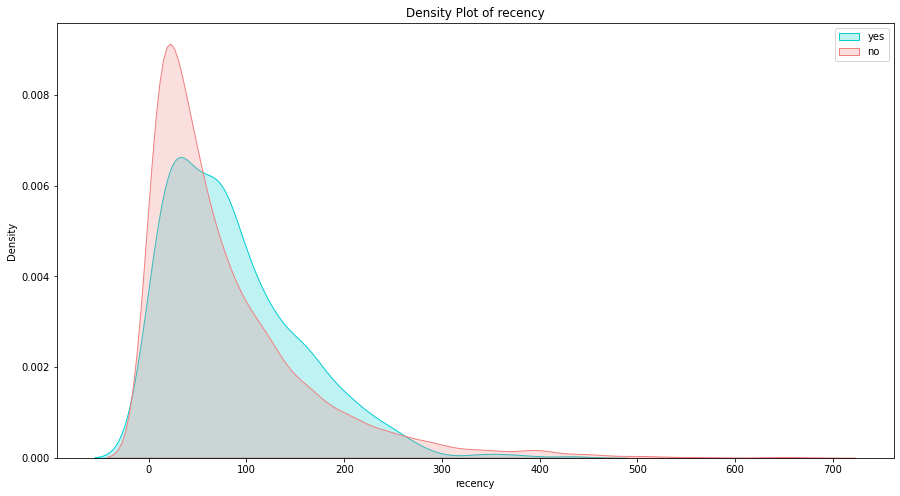

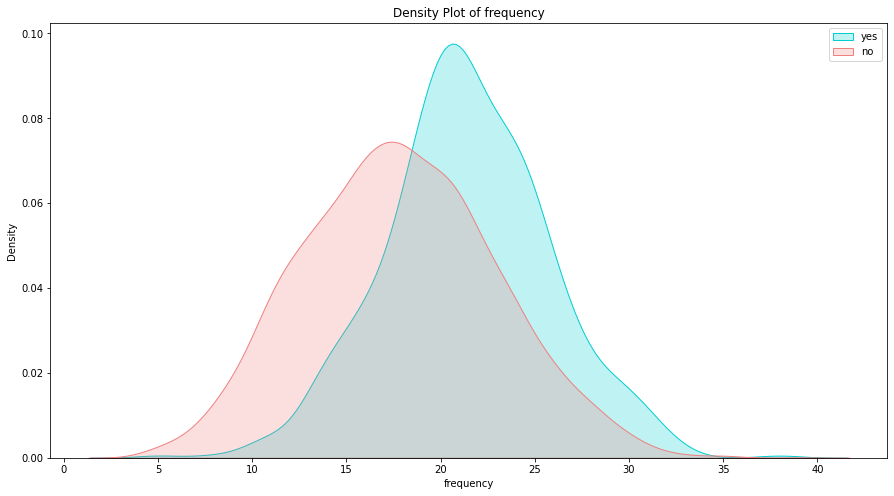

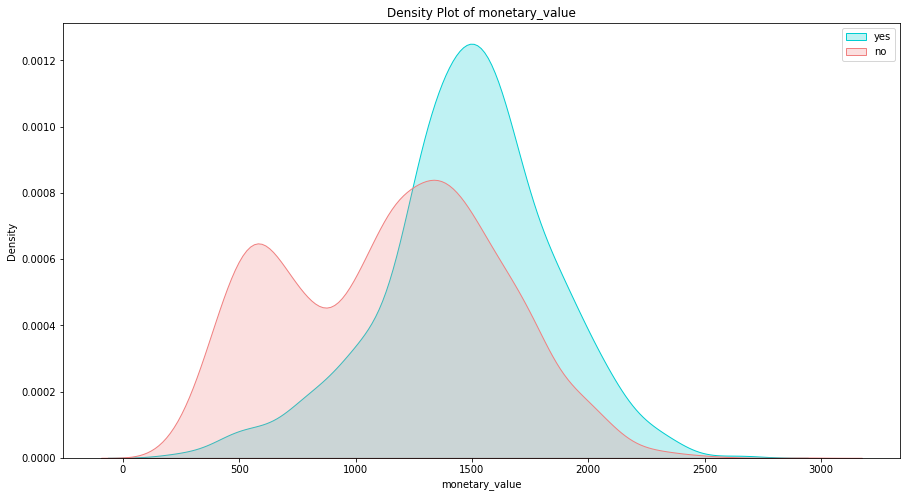

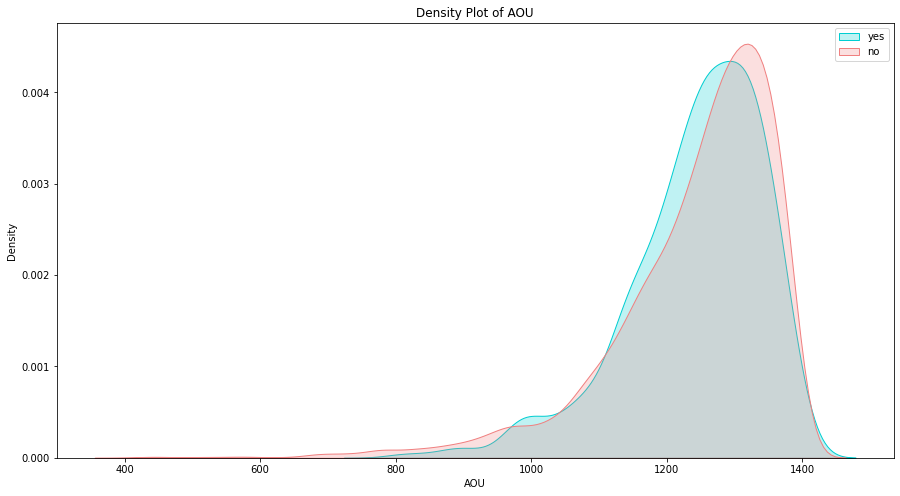

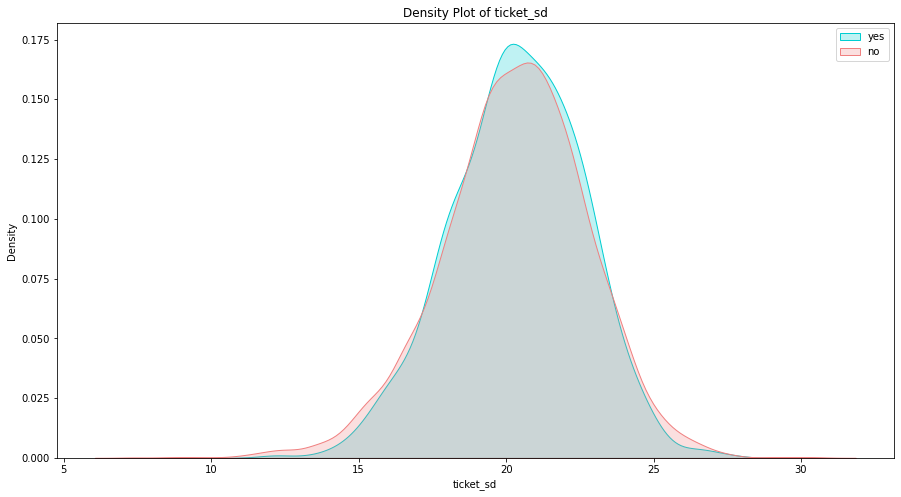

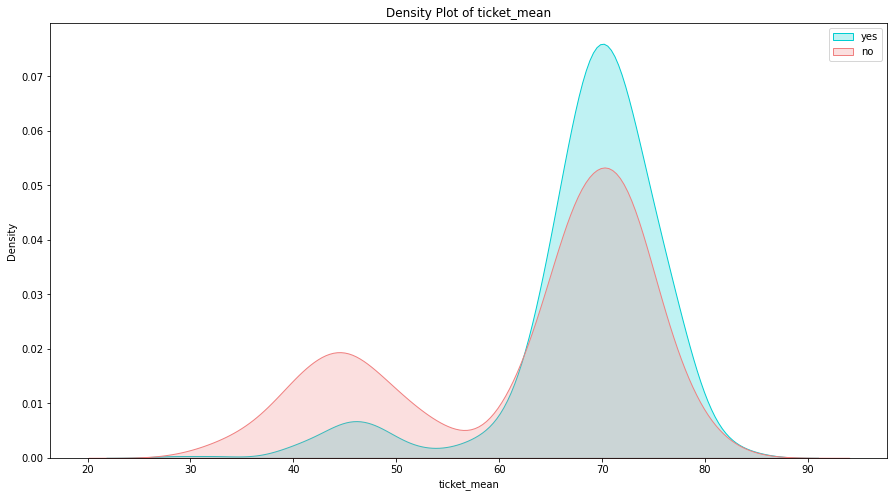

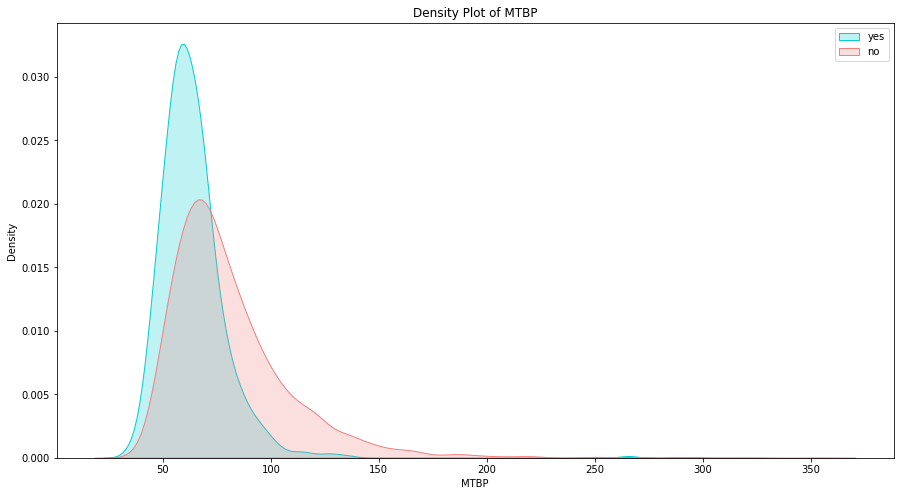

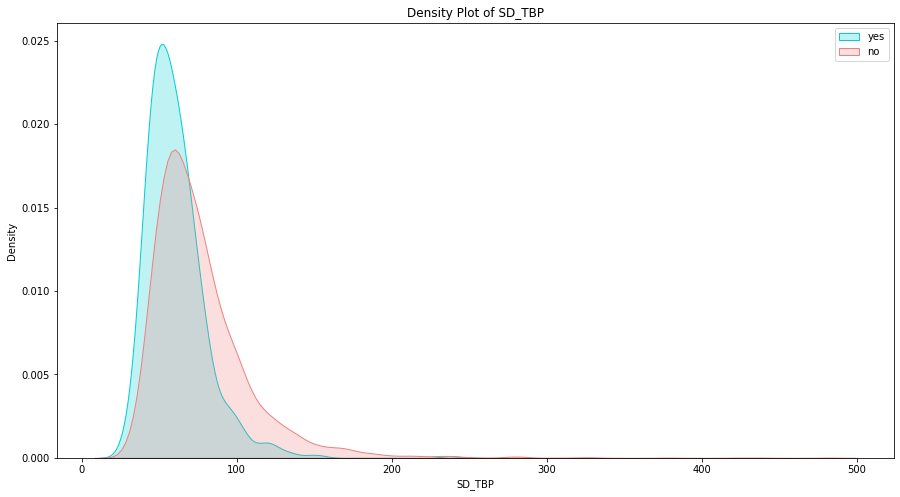

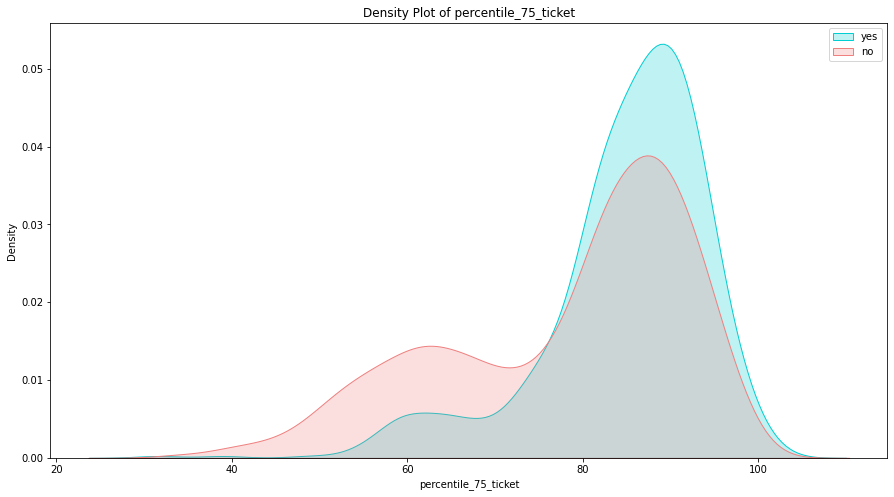

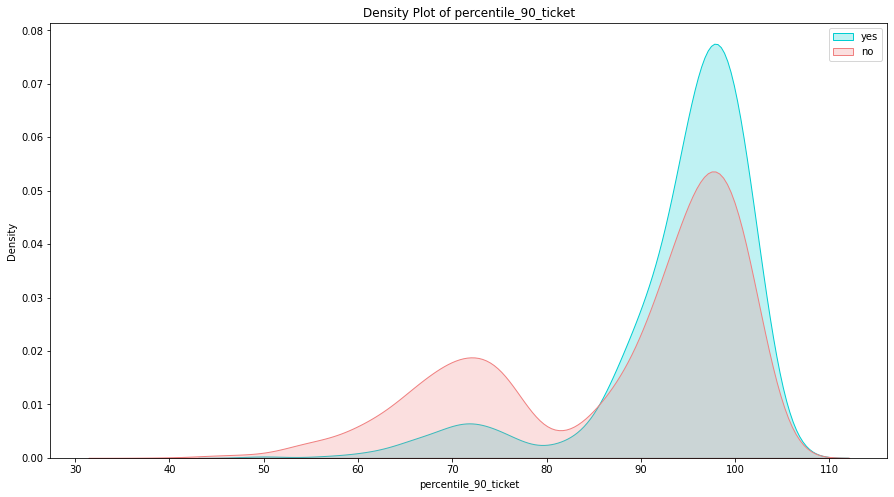

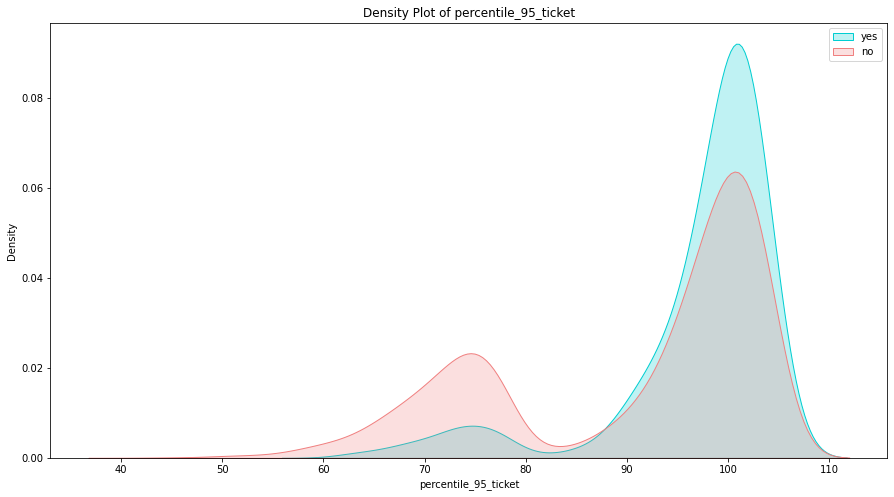

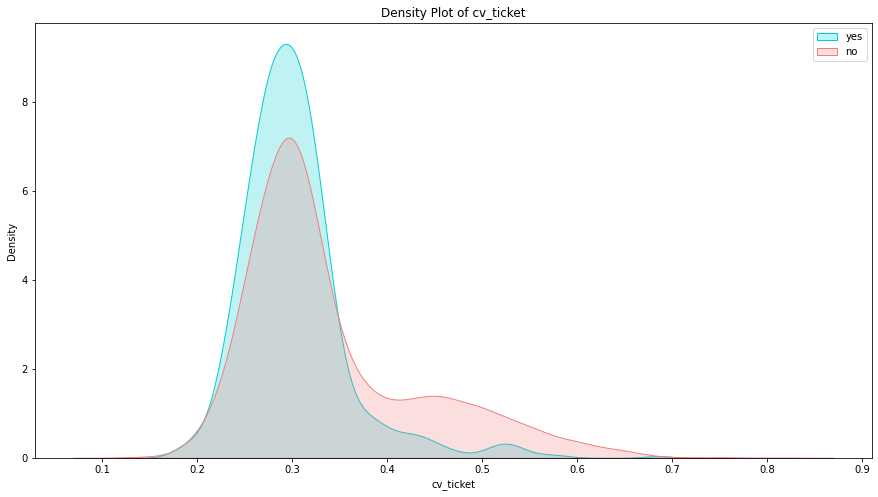

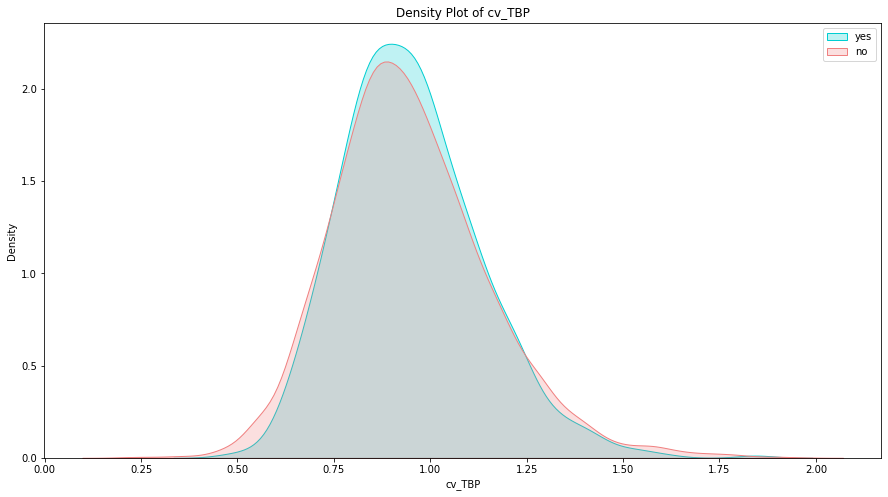

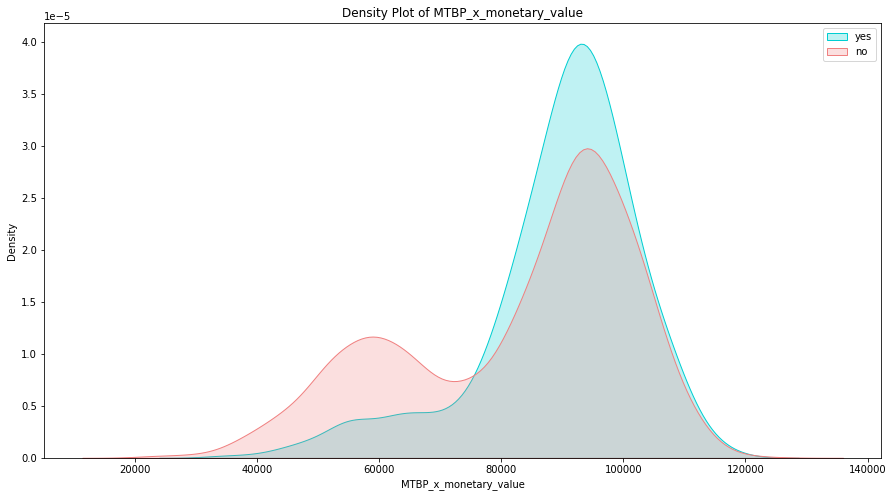

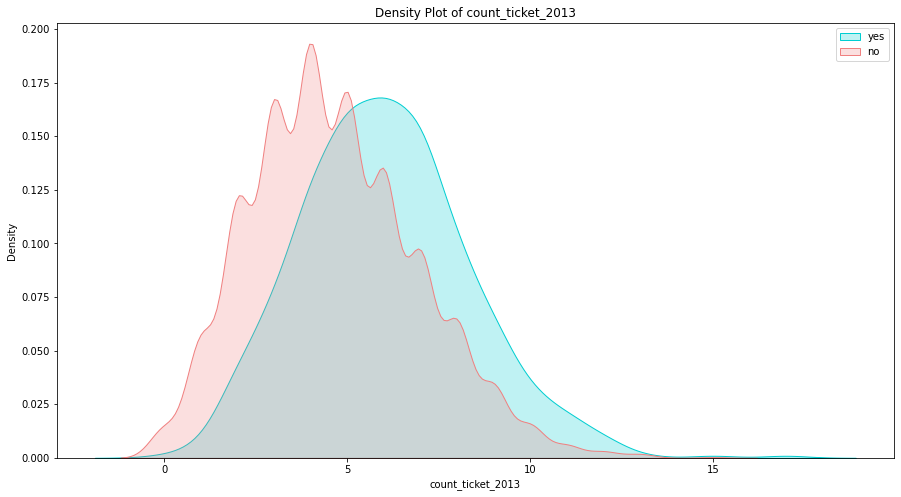

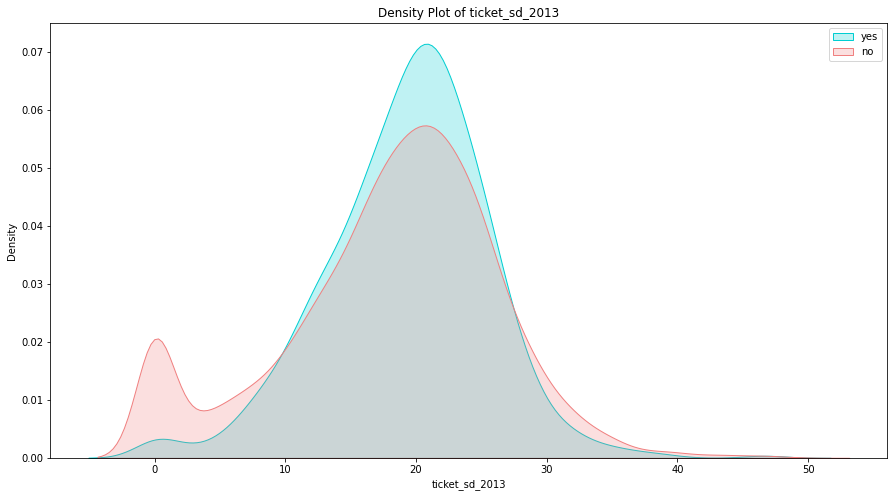

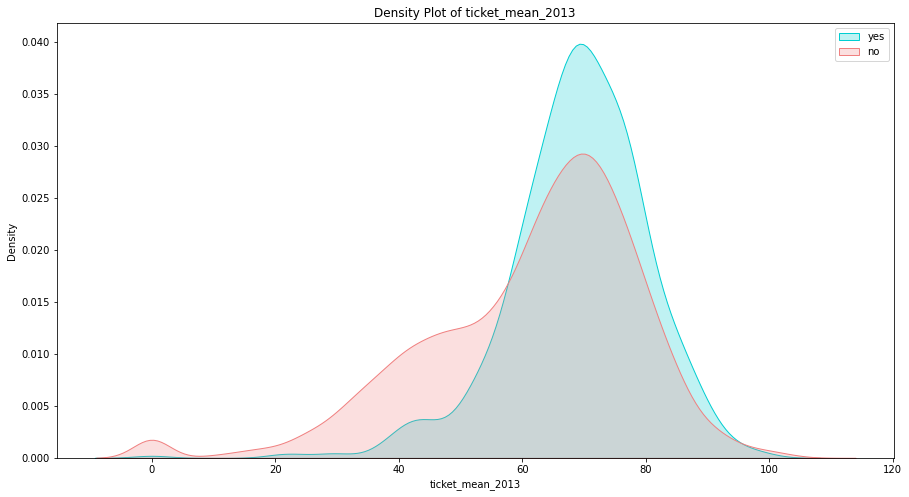

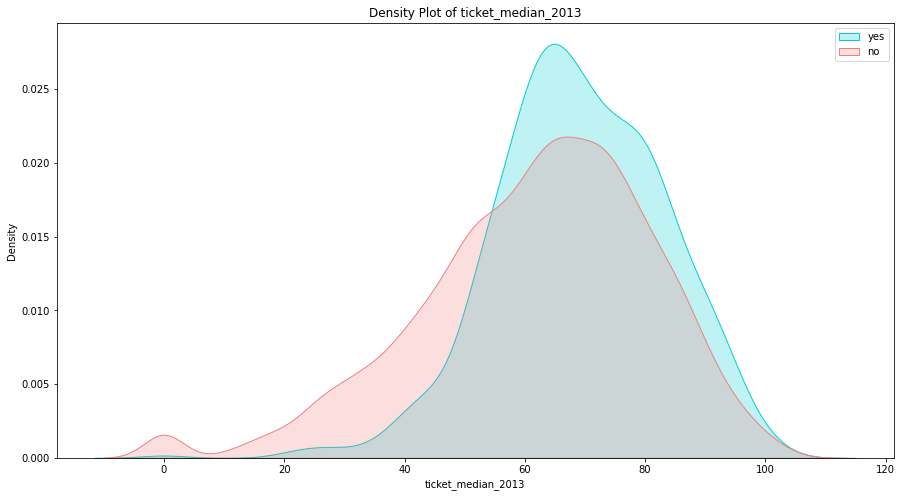

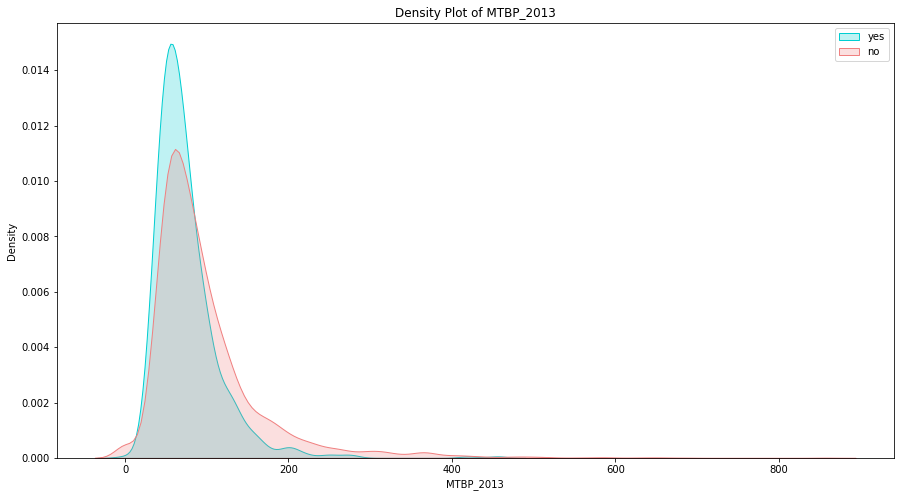

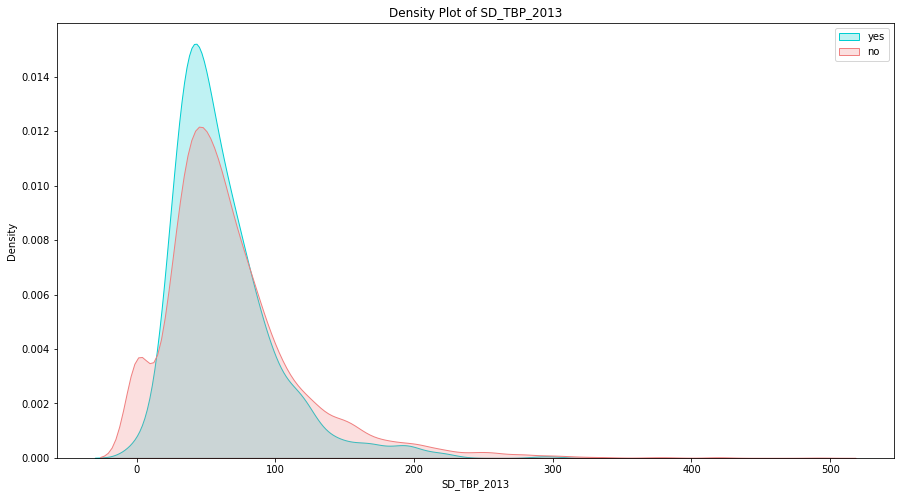

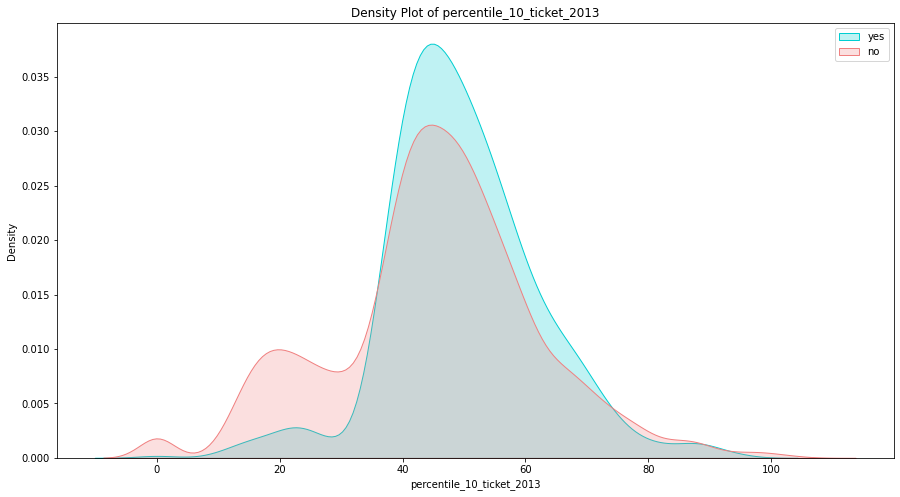

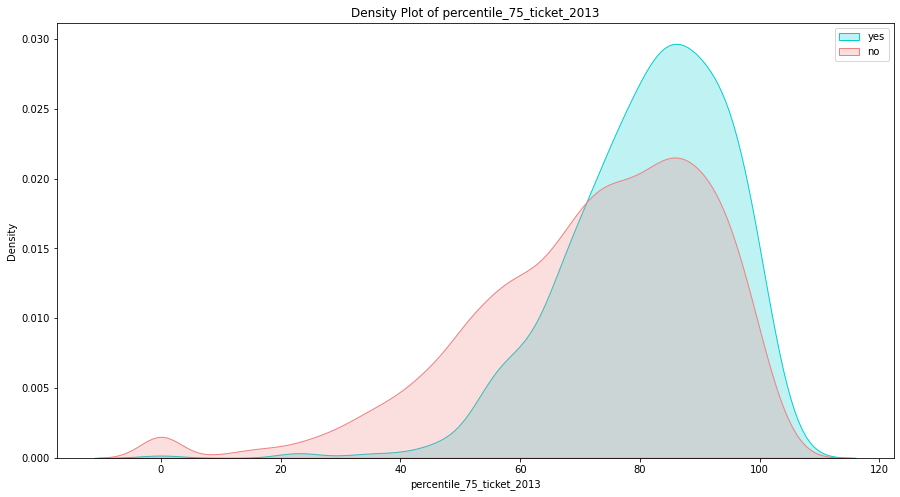

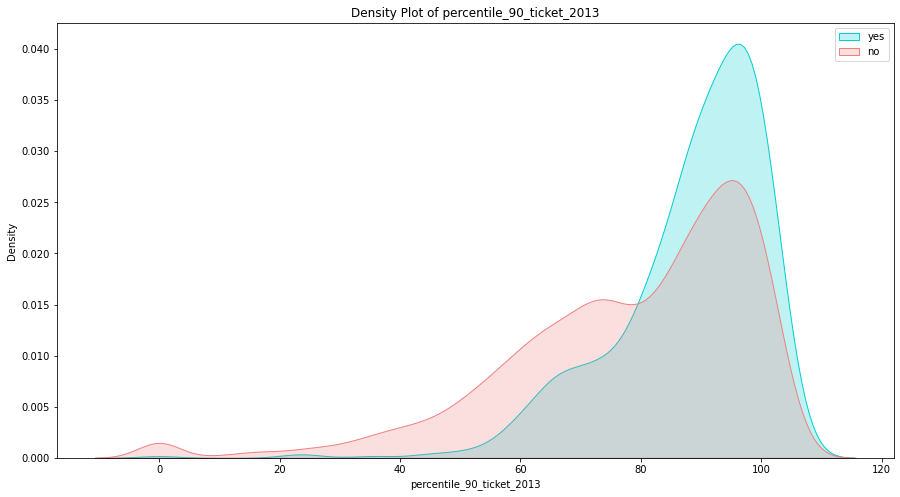

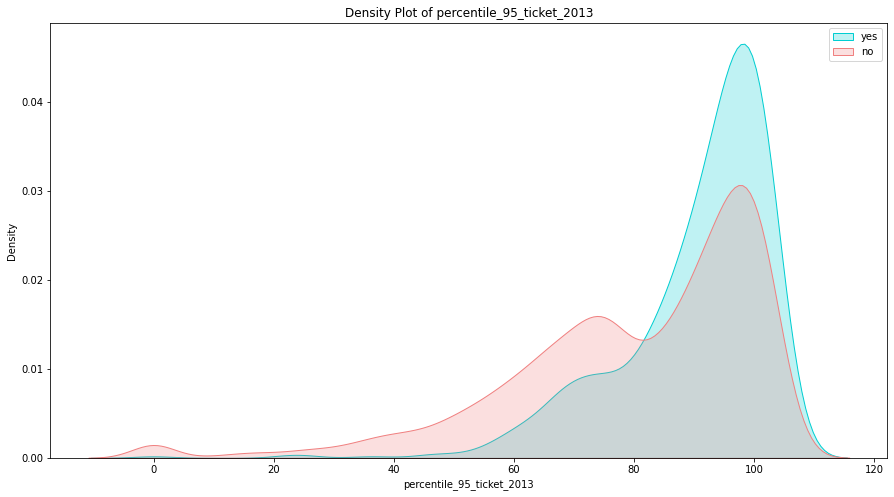

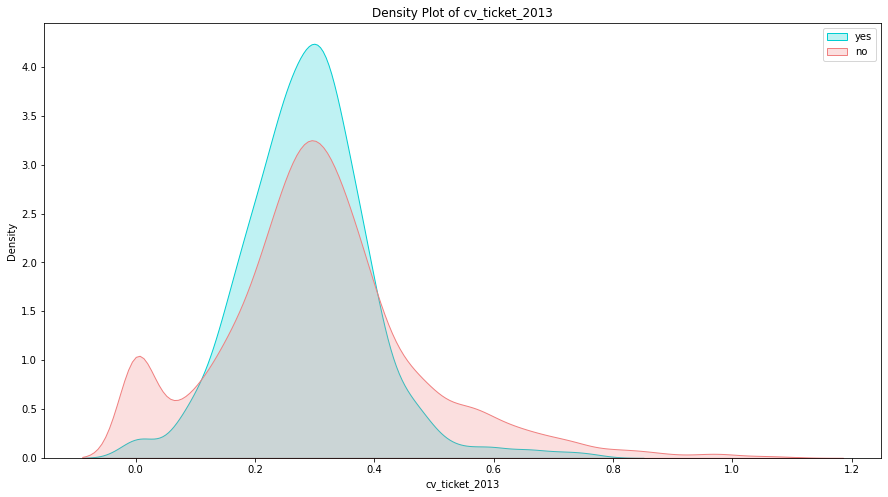

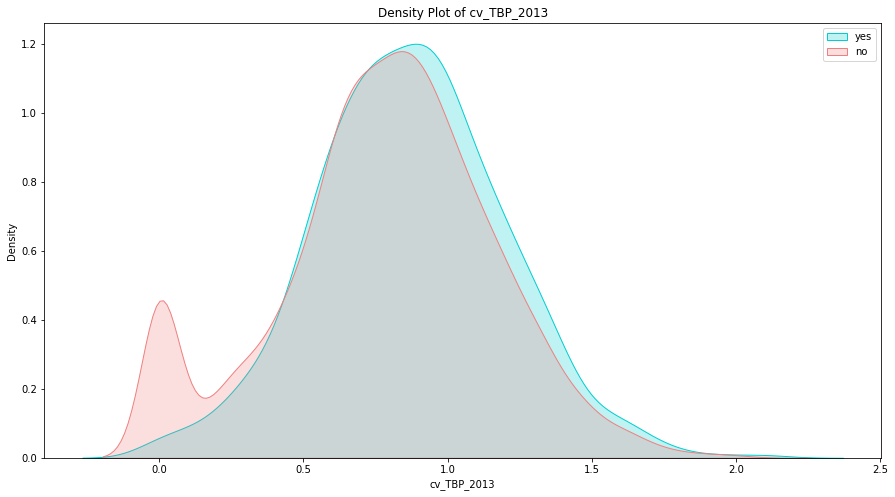

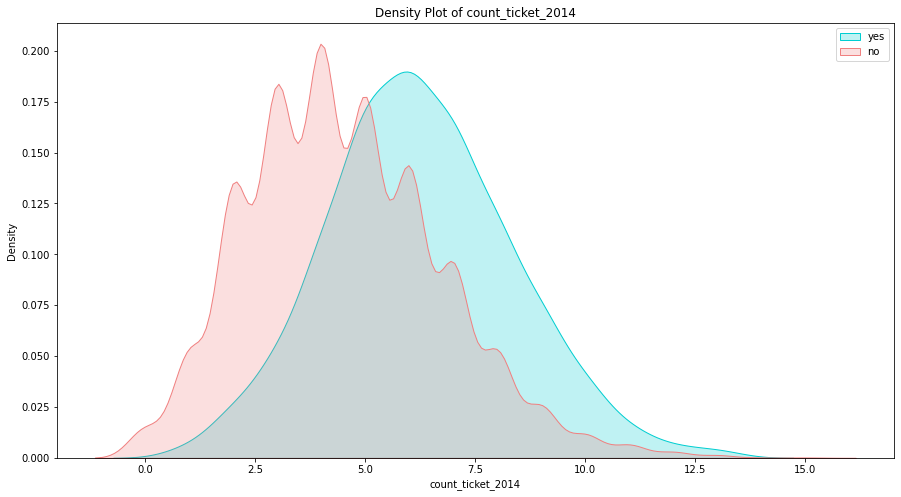

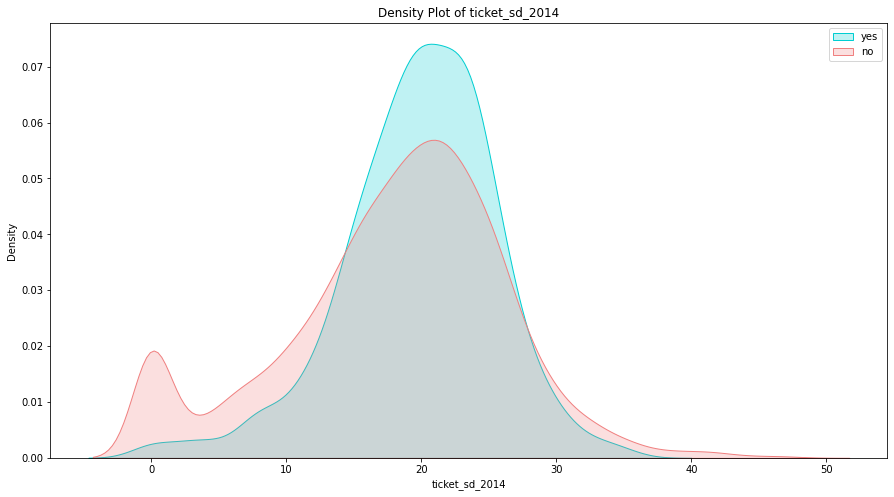

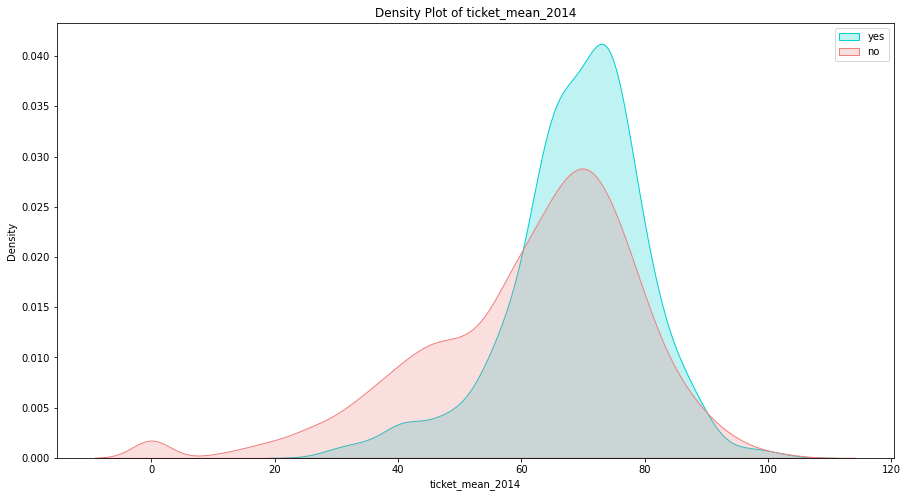

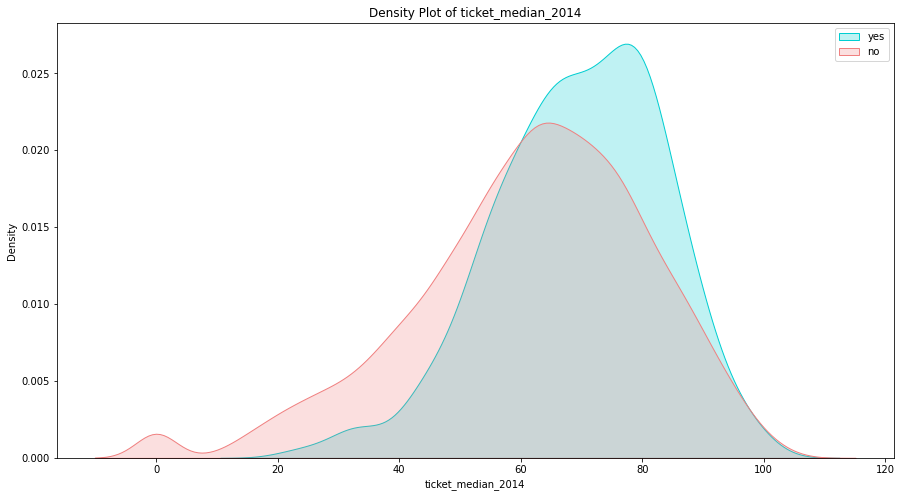

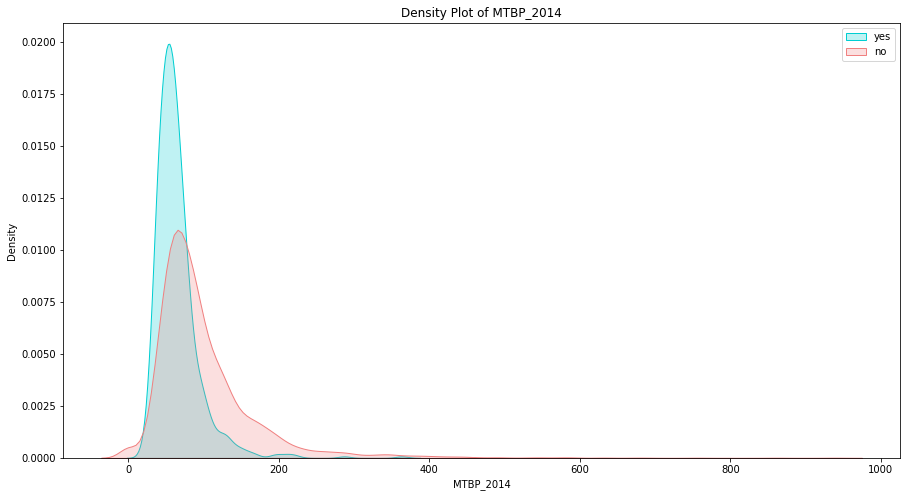

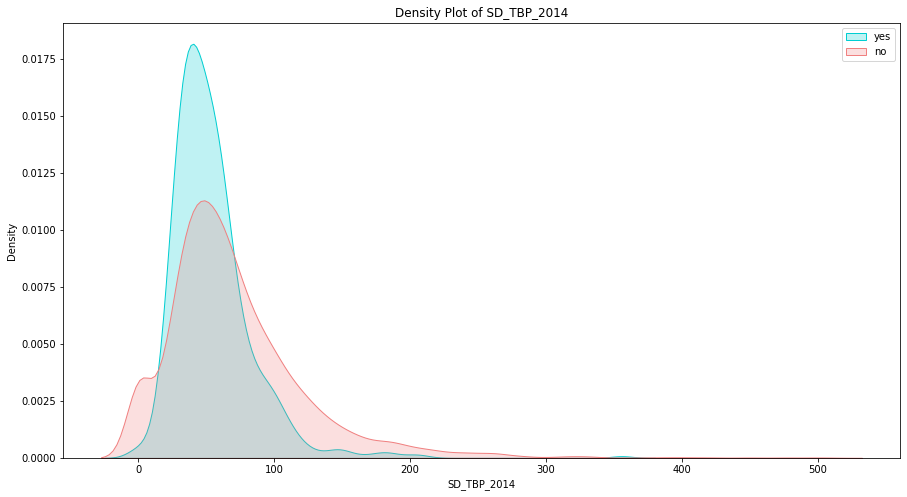

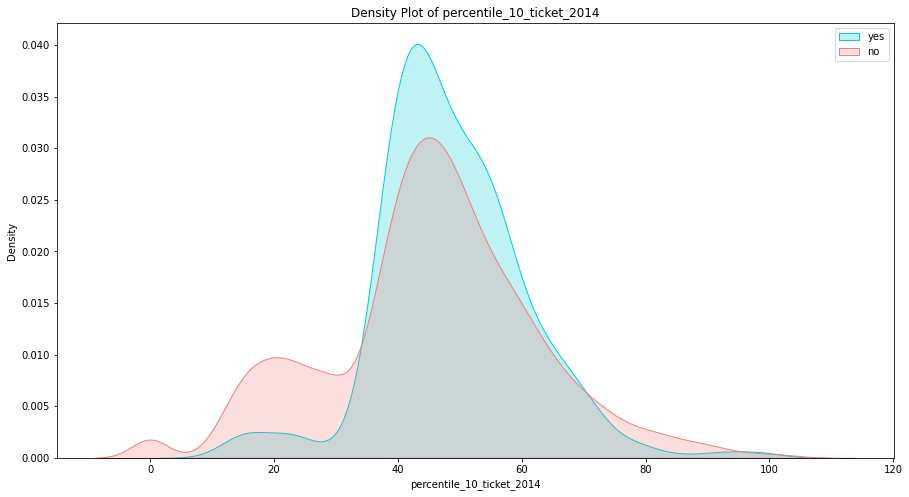

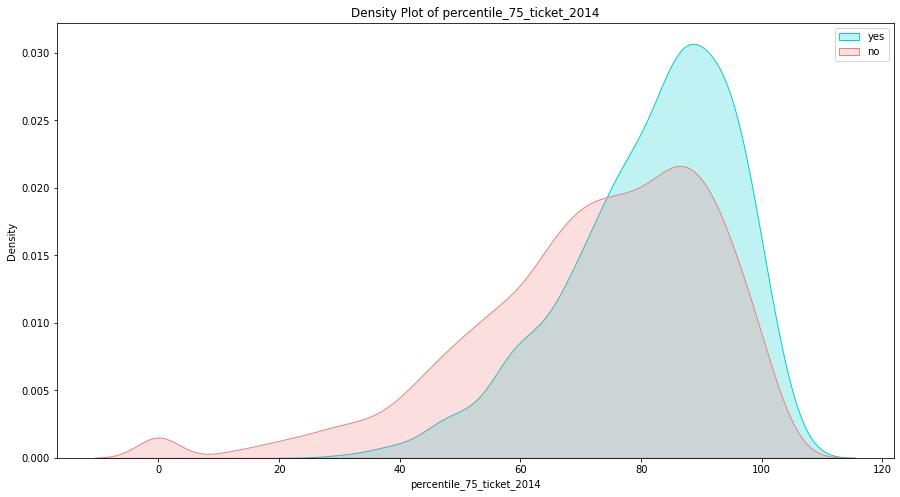

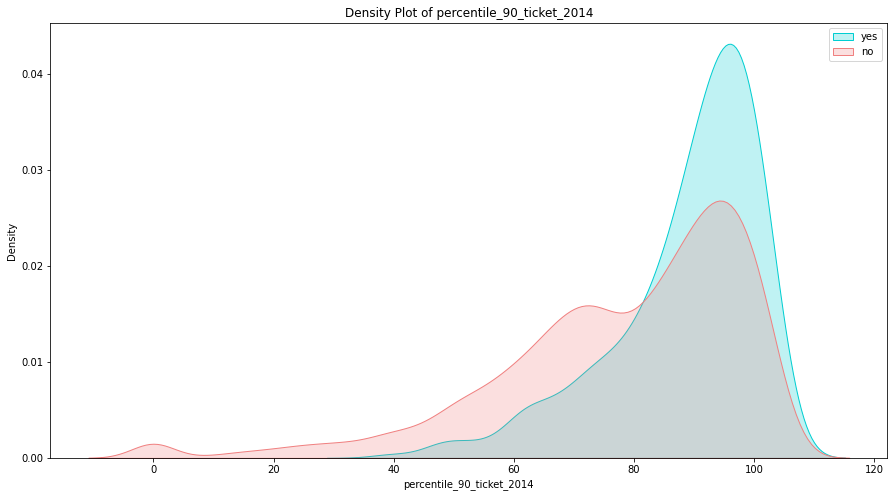

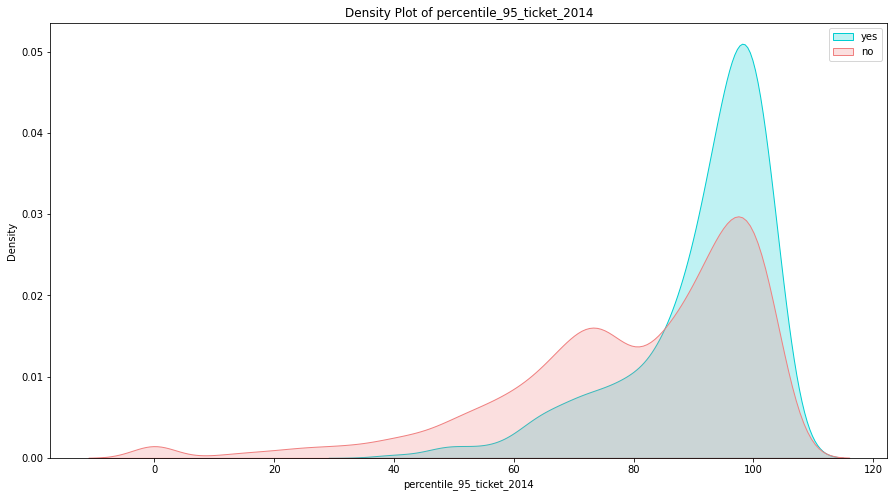

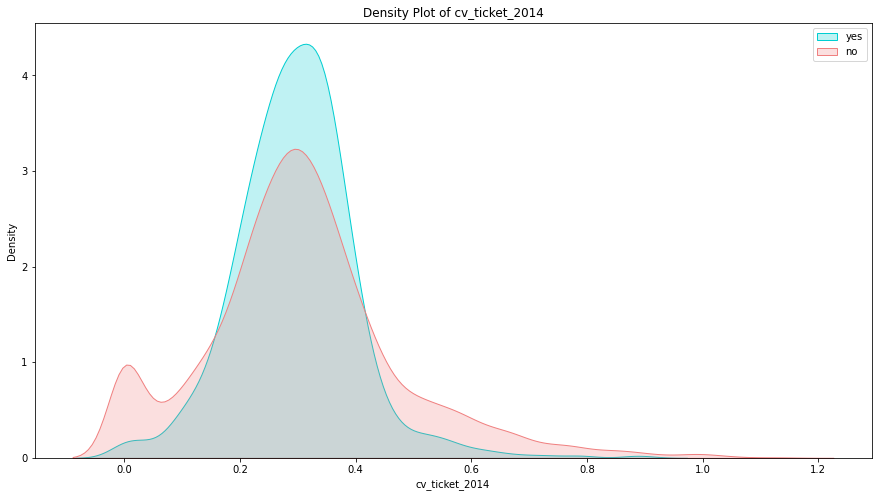

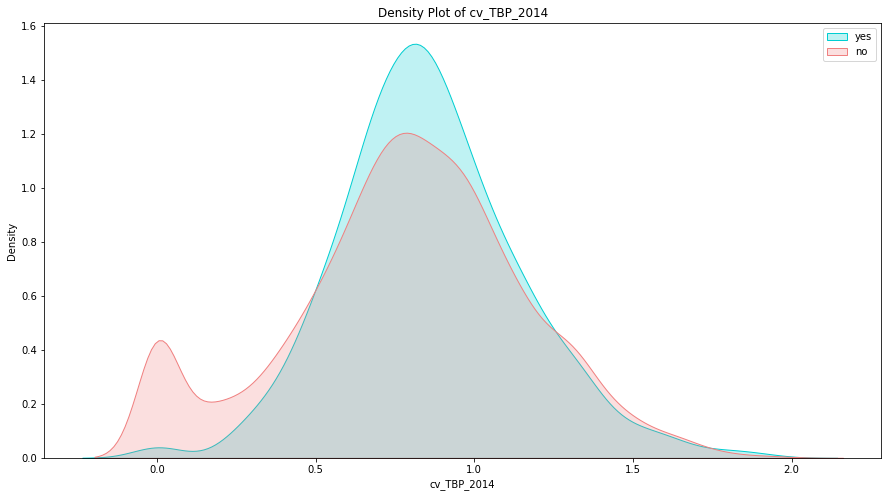

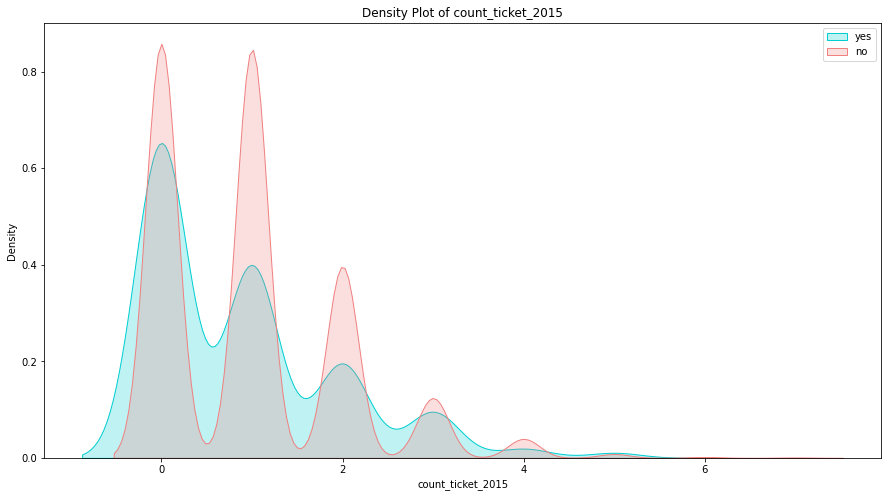

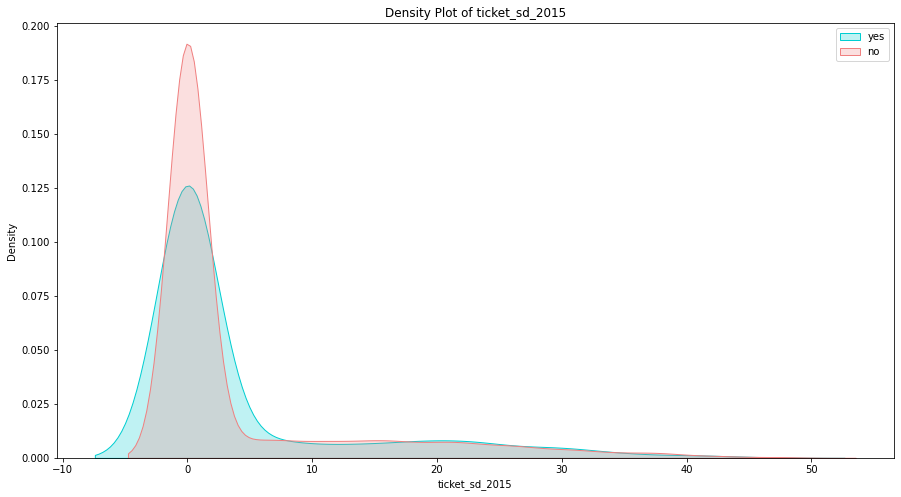

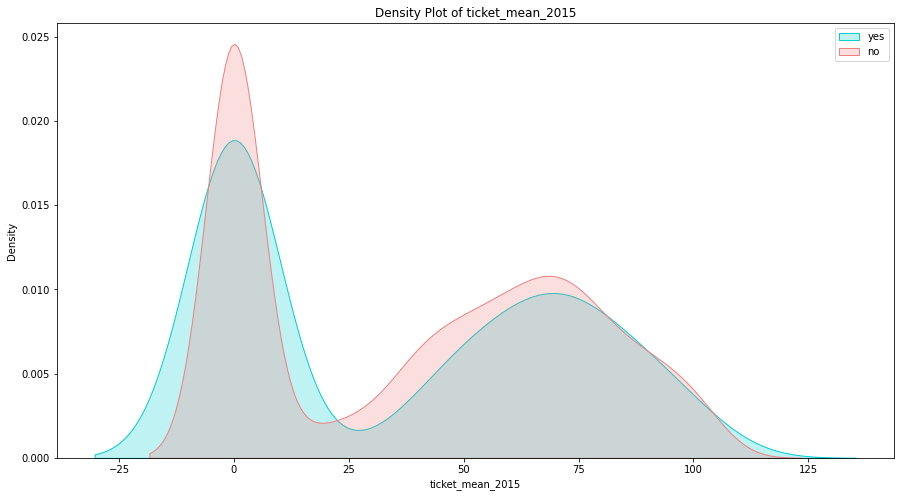

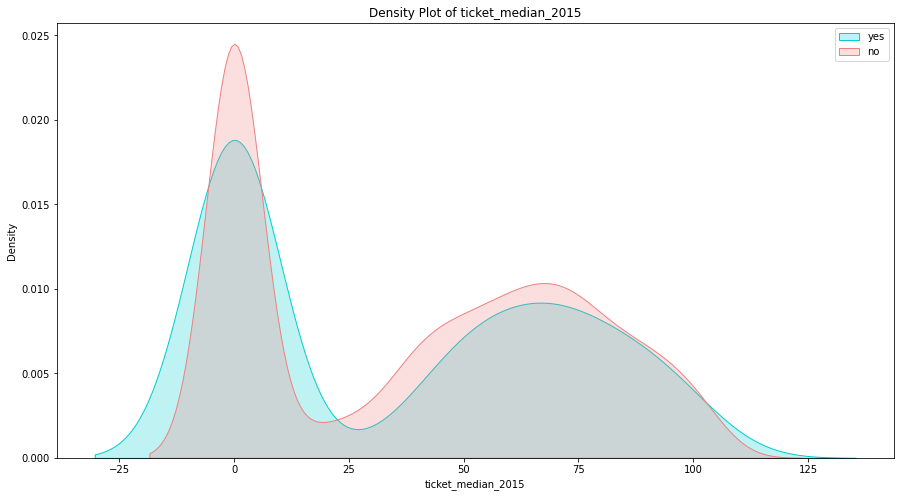

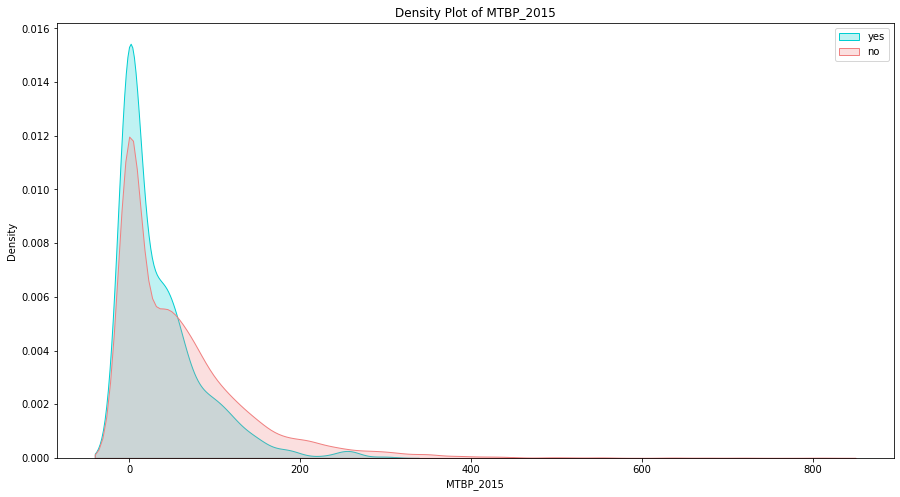

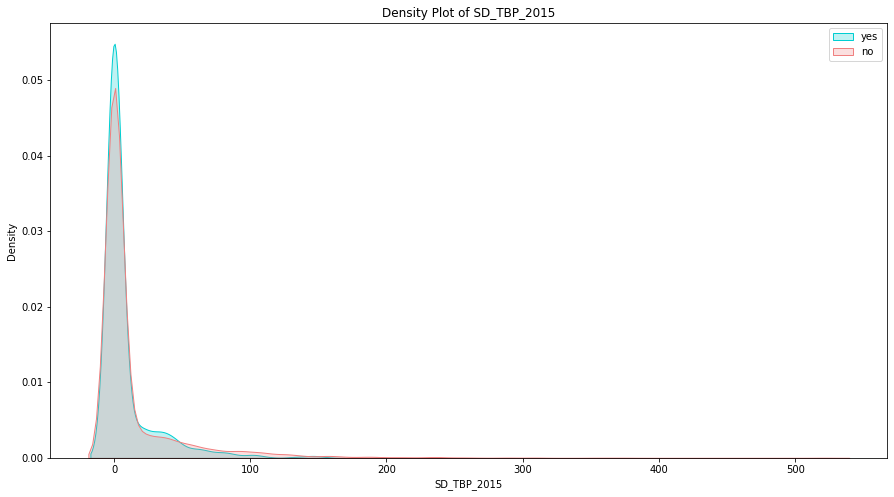

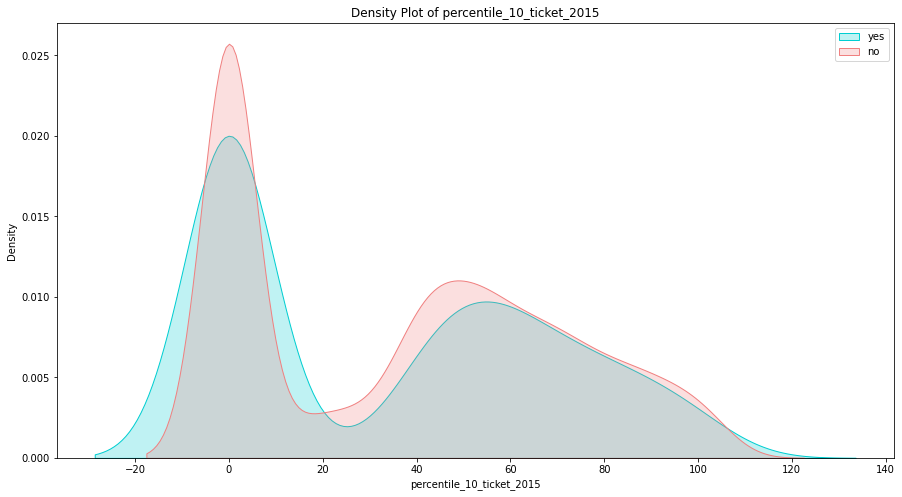

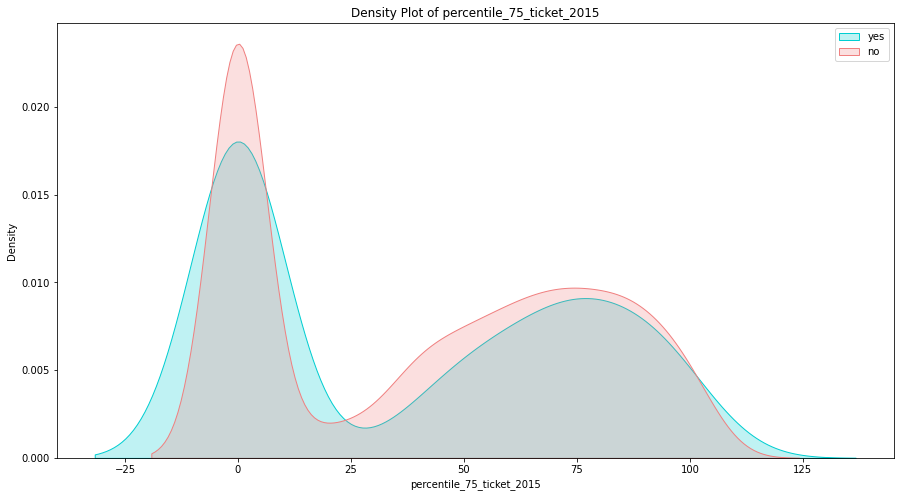

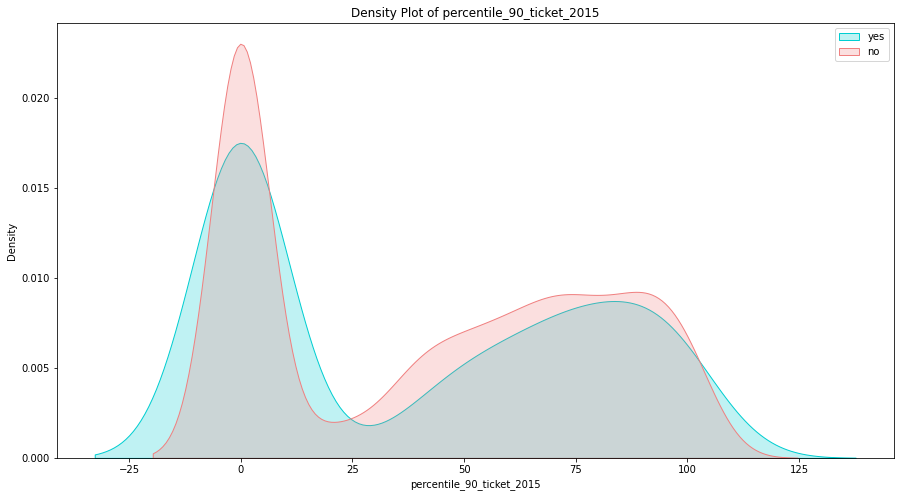

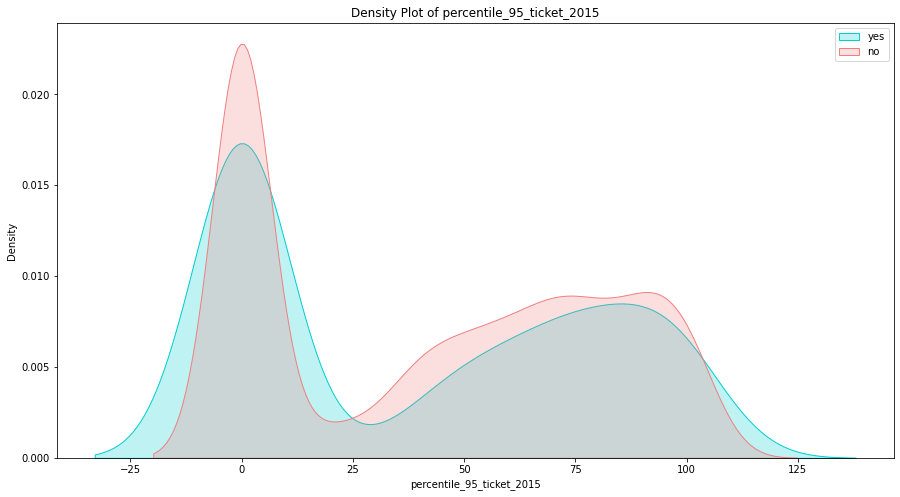

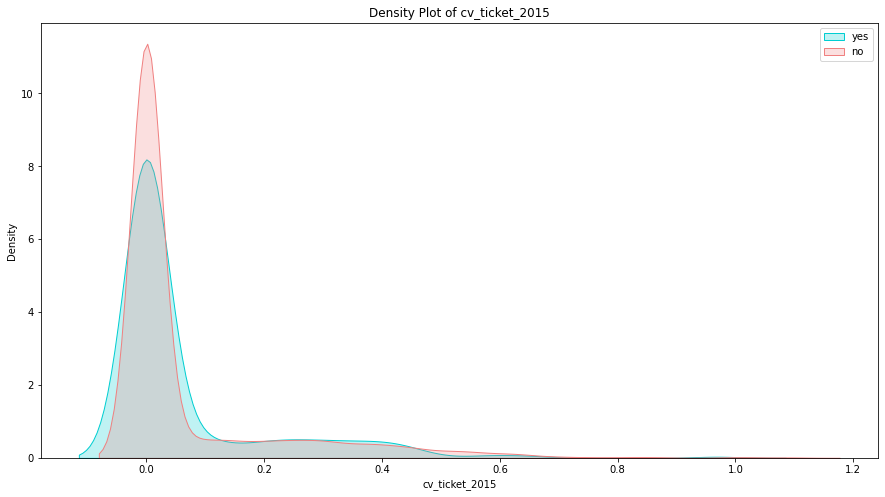

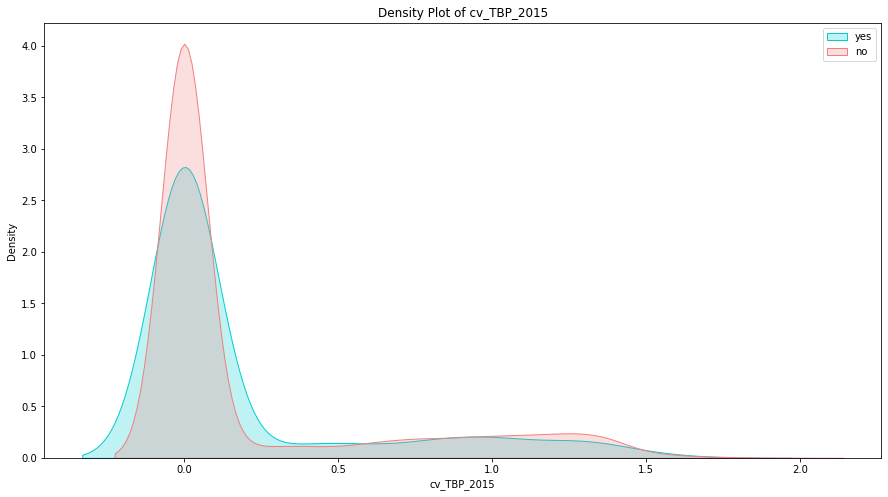

In [18]:
# Density Plots
for col in combined_df.columns[1:-1]:
  plt.figure(figsize=(15,8))
  ax = sns.kdeplot(combined_df[col][combined_df['response'] == 1], color="darkturquoise", shade=True)
  sns.kdeplot(combined_df[col][combined_df['response'] == 0], color="lightcoral", shade=True)
  plt.legend(['yes', 'no'])
  plt.title(f'Density Plot of {col}')
  ax.set(xlabel=col)
  plt.show()

In [19]:
#Calculating Response Rate
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

response  customer_id
0         0         6237
1         1          647

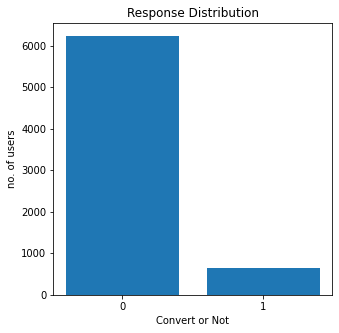

In [20]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

## **Creating Train and Test Datasets**

In [21]:
# selecting columns to be trained
df_modeling_clv = combined_df[['customer_id', 
                              'recency', 
                              'frequency', 
                              'monetary_value', 
                              #'AOU', 
                              #'ticket_sd',
                              'ticket_mean', 
                              'MTBP', 
                              'SD_TBP', 
                              #'percentile_75_ticket',
                              #'percentile_90_ticket', 
                              'percentile_95_ticket', 
                              'cv_ticket', 
                              #'cv_TBP',
                              #'MTBP_x_monetary_value', 
                              'count_ticket_2013', 
                              #'ticket_sd_2013',
                              'ticket_mean_2013',
                              'ticket_median_2013',  
                              'MTBP_2013', 
                              'SD_TBP_2013',
                              'percentile_10_ticket_2013', 
                              'percentile_75_ticket_2013', 
                              #'percentile_90_ticket_2013',
                              'percentile_95_ticket_2013', 
                              #'cv_ticket_2013', 
                              #'cv_TBP_2013',
                              'count_ticket_2014', 
                              'ticket_sd_2014', 
                              'ticket_mean_2014', 
                              'ticket_median_2014',  
                              'MTBP_2014',
                              'SD_TBP_2014', 
                              'percentile_10_ticket_2014',
                              #'percentile_75_ticket_2014', 
                              'percentile_90_ticket_2014',
                              'percentile_95_ticket_2014', 
                              'cv_ticket_2014', 
                              'cv_TBP_2014',
                              'count_ticket_2015', 
                              'ticket_sd_2015', 
                              'ticket_mean_2015', 
                              'ticket_median_2015',  
                              'MTBP_2015',
                              # 'SD_TBP_2015', 
                              'percentile_10_ticket_2015',
                              # 'percentile_75_ticket_2015', 
                              'percentile_90_ticket_2015',
                              'percentile_95_ticket_2015', 
                              # 'cv_ticket_2015', 
                              # 'cv_TBP_2015',
                              'response']]
df_modeling_clv

customer_id  recency  ...  percentile_95_ticket_2015  response
0         CS1112     62.0  ...                       39.0       0.0
1         CS1113     36.0  ...                       96.0       0.0
2         CS1114     33.0  ...                       79.0       1.0
3         CS1115     12.0  ...                       55.0       1.0
4         CS1116    204.0  ...                        0.0       1.0
...          ...      ...  ...                        ...       ...
6884      CS8996     98.0  ...                        0.0       0.0
6885      CS8997    262.0  ...                        0.0       0.0
6886      CS8998     85.0  ...                        0.0       0.0
6887      CS8999    258.0  ...                        0.0       0.0
6888      CS9000     17.0  ...                       34.0       0.0

[6889 rows x 37 columns]

In [22]:
#dropping customer without response label
df_modeling_clv = df_modeling_clv[~(df_modeling_clv['response'].isnull())]
df_modeling_clv.isnull().sum()

customer_id                  0
recency                      0
frequency                    0
monetary_value               0
ticket_mean                  0
MTBP                         0
SD_TBP                       0
percentile_95_ticket         0
cv_ticket                    0
count_ticket_2013            0
ticket_mean_2013             0
ticket_median_2013           0
MTBP_2013                    0
SD_TBP_2013                  0
percentile_10_ticket_2013    0
percentile_75_ticket_2013    0
percentile_95_ticket_2013    0
count_ticket_2014            0
ticket_sd_2014               0
ticket_mean_2014             0
ticket_median_2014           0
MTBP_2014                    0
SD_TBP_2014                  0
percentile_10_ticket_2014    0
percentile_90_ticket_2014    0
percentile_95_ticket_2014    0
cv_ticket_2014               0
cv_TBP_2014                  0
count_ticket_2015            0
ticket_sd_2015               0
ticket_mean_2015             0
ticket_median_2015           0
MTBP_201

In [23]:
## spliting dataframe into X and y
X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
y_clv = df_modeling_clv['response']

## creating train and test dataset
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.3, random_state=0)

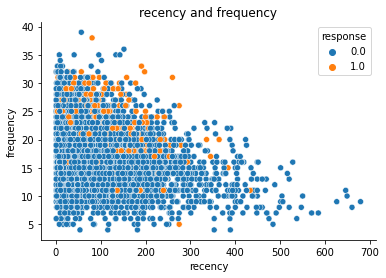

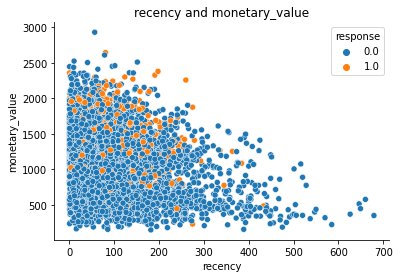

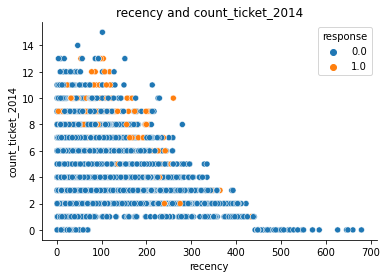

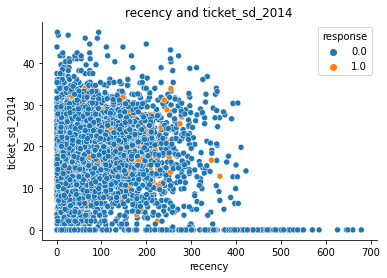

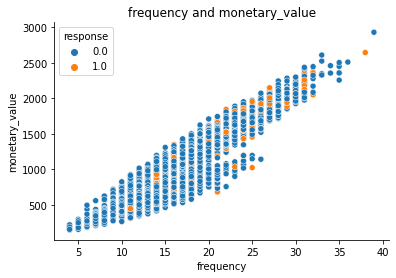

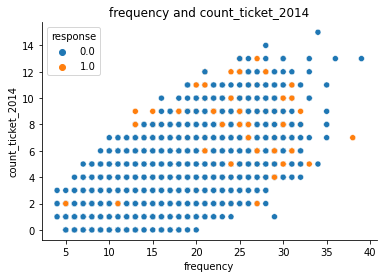

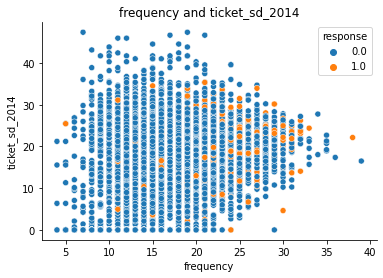

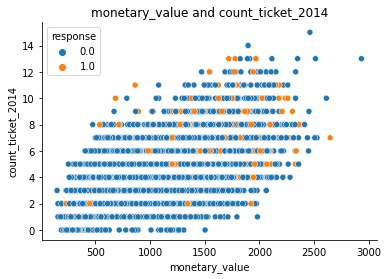

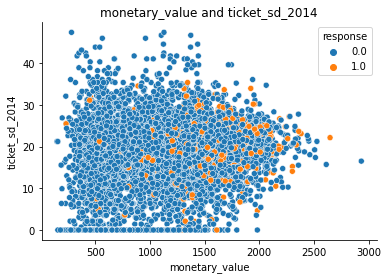

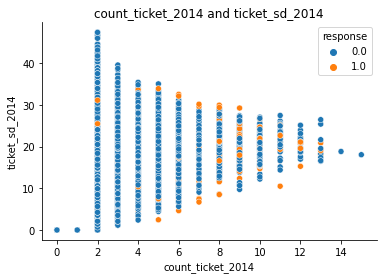

In [24]:
for i, col_i in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'count_ticket_2014', 'ticket_sd_2014']].columns):
  for j, col_j in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'count_ticket_2014', 'ticket_sd_2014']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_clv, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

## **Fixing Imbalanced Data**

#### SMOTE

In [25]:
sm = SMOTE(random_state=0)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_resample(X_train_clv, y_train_clv)

#### Undersampling

In [26]:
rus = RandomUnderSampler(random_state=0)

rus.fit(X_train_clv, y_train_clv)
X_under_clv, y_under_clv = rus.fit_resample(X_train_clv, y_train_clv)

#### Oversampling

In [27]:
ros = RandomOverSampler(random_state=0)

ros.fit(X_train_clv, y_train_clv)
X_over_clv, y_over_clv = ros.fit_resample(X_train_clv, y_train_clv)

## **Feature Importance**

[0]	validation_0-auc:0.736123
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.745147
[2]	validation_0-auc:0.767937
[3]	validation_0-auc:0.76921
[4]	validation_0-auc:0.772437
[5]	validation_0-auc:0.775614
[6]	validation_0-auc:0.775435
[7]	validation_0-auc:0.774756
[8]	validation_0-auc:0.77988
[9]	validation_0-auc:0.782887
[10]	validation_0-auc:0.782142
[11]	validation_0-auc:0.785336
[12]	validation_0-auc:0.784919
[13]	validation_0-auc:0.788669
[14]	validation_0-auc:0.788728
[15]	validation_0-auc:0.789001
[16]	validation_0-auc:0.790649
[17]	validation_0-auc:0.791545
[18]	validation_0-auc:0.792606
[19]	validation_0-auc:0.792808
[20]	validation_0-auc:0.793258
[21]	validation_0-auc:0.793749
[22]	validation_0-auc:0.794438
[23]	validation_0-auc:0.794494
[24]	validation_0-auc:0.795085
[25]	validation_0-auc:0.795647
[26]	validation_0-auc:0.796717
[27]	validation_0-auc:0.796454
[28]	validation_0-auc:0.798032
[29]	validation_0-auc:0.798695
[30]	validation_0-a

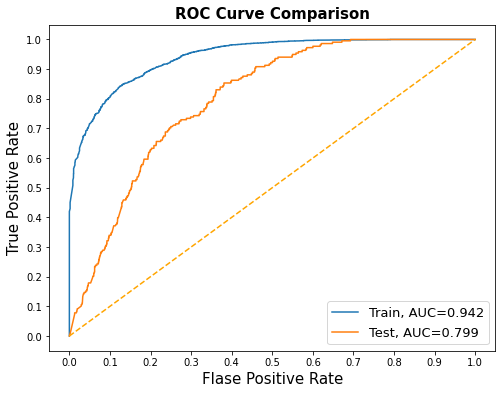

[0]	validation_0-auc:0.71799
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.750395
[2]	validation_0-auc:0.749769
[3]	validation_0-auc:0.750989
[4]	validation_0-auc:0.757871
[5]	validation_0-auc:0.759315
[6]	validation_0-auc:0.763292
[7]	validation_0-auc:0.766501
[8]	validation_0-auc:0.768408
[9]	validation_0-auc:0.772446
[10]	validation_0-auc:0.774708
[11]	validation_0-auc:0.775232
[12]	validation_0-auc:0.773651
[13]	validation_0-auc:0.774291
[14]	validation_0-auc:0.772871
[15]	validation_0-auc:0.773474
[16]	validation_0-auc:0.775811
[17]	validation_0-auc:0.777239
[18]	validation_0-auc:0.776926
[19]	validation_0-auc:0.777899
[20]	validation_0-auc:0.77832
[21]	validation_0-auc:0.77929
[22]	validation_0-auc:0.779918
[23]	validation_0-auc:0.783716
[24]	validation_0-auc:0.783254
[25]	validation_0-auc:0.781987
[26]	validation_0-auc:0.782198
[27]	validation_0-auc:0.783854
[28]	validation_0-auc:0.783019
[29]	validation_0-auc:0.782418
[30]	validation_0-au

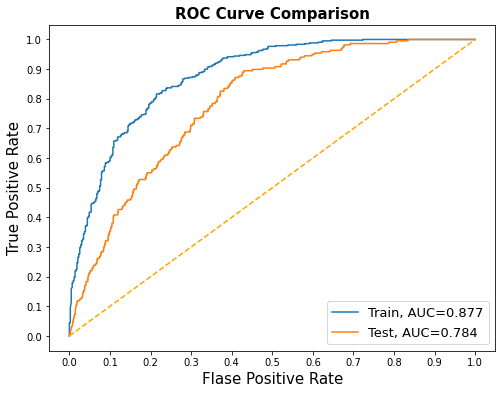

[0]	validation_0-auc:0.743358
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.739993
[2]	validation_0-auc:0.741755
[3]	validation_0-auc:0.754642
[4]	validation_0-auc:0.765488
[5]	validation_0-auc:0.767946
[6]	validation_0-auc:0.767618
[7]	validation_0-auc:0.768073
[8]	validation_0-auc:0.772735
[9]	validation_0-auc:0.776904
[10]	validation_0-auc:0.776453
[11]	validation_0-auc:0.774832
[12]	validation_0-auc:0.777967
[13]	validation_0-auc:0.779342
[14]	validation_0-auc:0.780725
[15]	validation_0-auc:0.780479
[16]	validation_0-auc:0.781408
[17]	validation_0-auc:0.781225
[18]	validation_0-auc:0.782744
[19]	validation_0-auc:0.782662
[20]	validation_0-auc:0.782974
[21]	validation_0-auc:0.783194
[22]	validation_0-auc:0.782868
[23]	validation_0-auc:0.782986
[24]	validation_0-auc:0.782435
[25]	validation_0-auc:0.782284
[26]	validation_0-auc:0.783021
Stopping. Best iteration:
[21]	validation_0-auc:0.783194

Training set
              precision    recall  f1-s

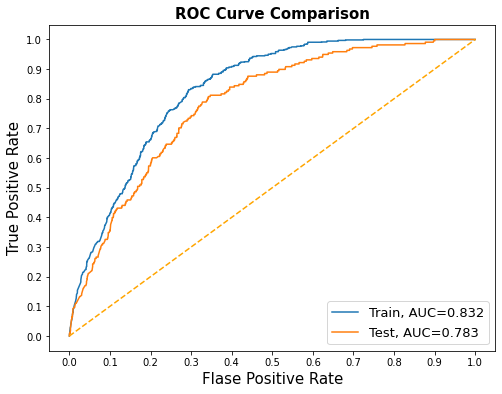

In [28]:
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc')

fitted_model_SMOTE = run_model(model, X_SMOTE_clv, y_SMOTE_clv, X_test_clv,  y_test_clv, xgb='yes')
fitted_model_under = run_model(model, X_under_clv, y_under_clv, X_test_clv,  y_test_clv, xgb='yes')
fitted_model_over = run_model(model, X_over_clv, y_over_clv, X_test_clv,  y_test_clv, xgb='yes')

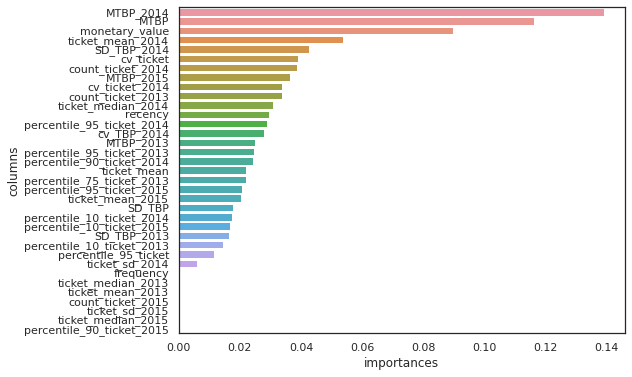

In [29]:
feature_importance_clf = pd.DataFrame(list(zip(X_train_clv.columns, fitted_model_over.feature_importances_)), columns =['columns', 'importances'])
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("white")
sns.barplot(x="importances", y="columns", data=feature_importance_clf.sort_values('importances',ascending=False))

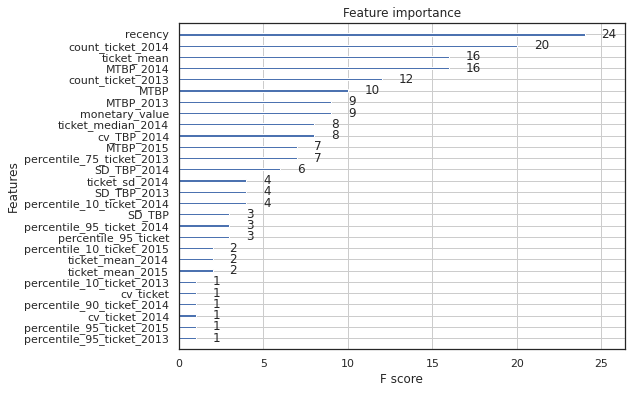

In [30]:
plot_importance(fitted_model_over)

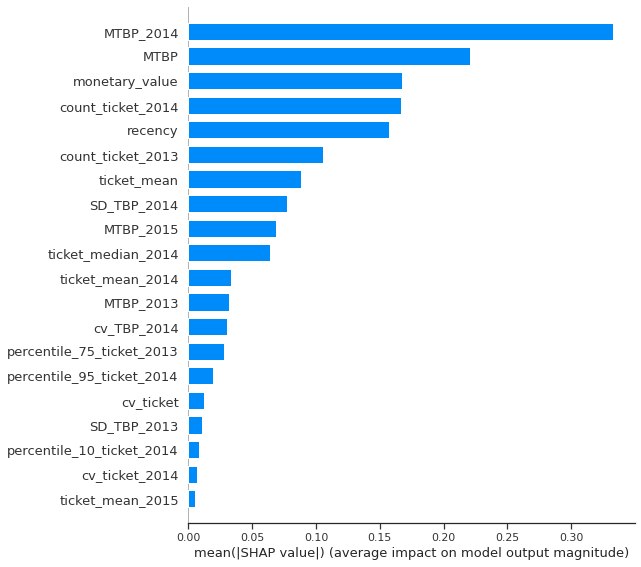

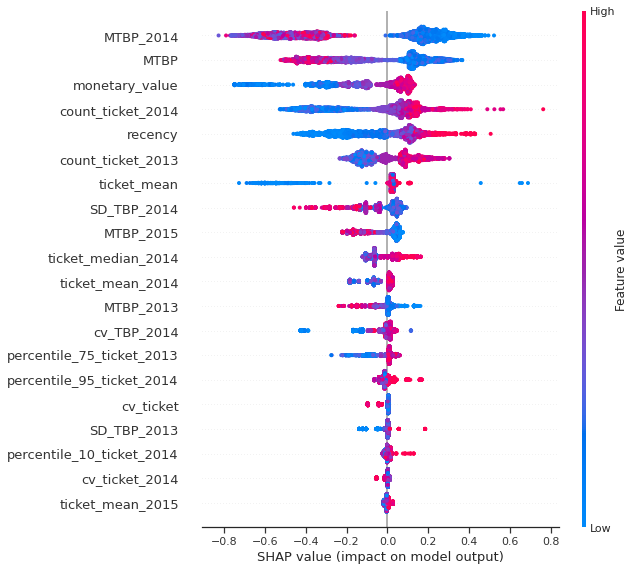

In [31]:
shap_values = shap.TreeExplainer(fitted_model_over).shap_values(X_train_clv)
shap.summary_plot(shap_values, X_train_clv, plot_type="bar")

f = plt.figure()
shap.summary_plot(shap_values, X_train_clv)

## **Logistic Regression**

Training set
              precision    recall  f1-score   support

         0.0       0.78      0.71      0.74      4389
         1.0       0.74      0.80      0.77      4389

    accuracy                           0.76      8778
   macro avg       0.76      0.76      0.76      8778
weighted avg       0.76      0.76      0.76      8778

Train AUC score: 0.821456798648582
Test set
              precision    recall  f1-score   support

         0.0       0.95      0.72      0.82      1848
         1.0       0.23      0.71      0.34       218

    accuracy                           0.72      2066
   macro avg       0.59      0.71      0.58      2066
weighted avg       0.88      0.72      0.77      2066

Test AUC score: 0.7833040430517495


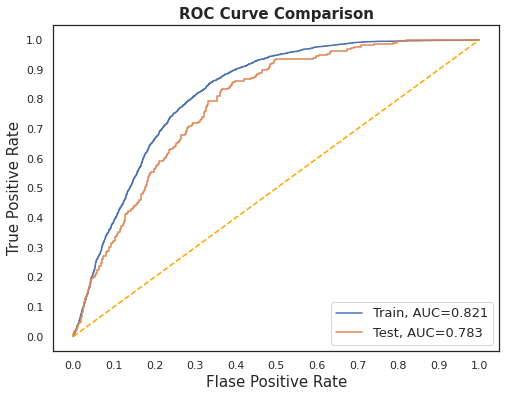

Training set
              precision    recall  f1-score   support

         0.0       0.72      0.67      0.70       429
         1.0       0.69      0.75      0.72       429

    accuracy                           0.71       858
   macro avg       0.71      0.71      0.71       858
weighted avg       0.71      0.71      0.71       858

Train AUC score: 0.7794839193440593
Test set
              precision    recall  f1-score   support

         0.0       0.97      0.66      0.78      1848
         1.0       0.22      0.83      0.35       218

    accuracy                           0.68      2066
   macro avg       0.60      0.74      0.57      2066
weighted avg       0.89      0.68      0.74      2066

Test AUC score: 0.7817923666547519


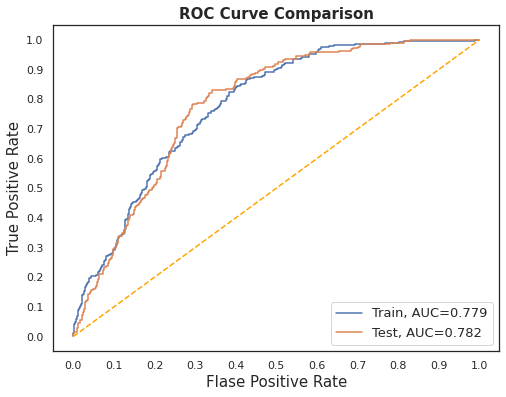

Training set
              precision    recall  f1-score   support

         0.0       0.73      0.67      0.70      4389
         1.0       0.70      0.76      0.73      4389

    accuracy                           0.71      8778
   macro avg       0.72      0.71      0.71      8778
weighted avg       0.72      0.71      0.71      8778

Train AUC score: 0.7762443973186138
Test set
              precision    recall  f1-score   support

         0.0       0.97      0.66      0.79      1848
         1.0       0.22      0.81      0.35       218

    accuracy                           0.68      2066
   macro avg       0.59      0.74      0.57      2066
weighted avg       0.89      0.68      0.74      2066

Test AUC score: 0.7940247825568926


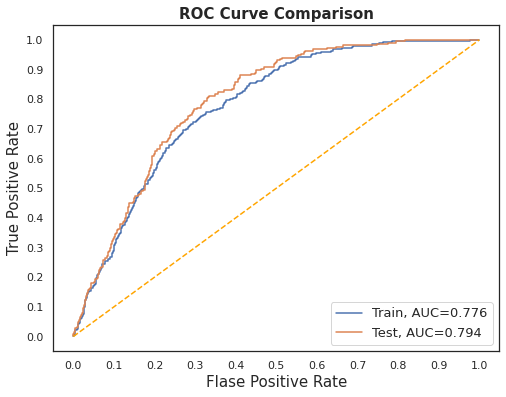

In [32]:
model = LogisticRegression(solver='liblinear', class_weight='balanced')

fitted_model_SMOTE = run_model(model, X_SMOTE_clv, y_SMOTE_clv, X_test_clv,  y_test_clv, xgb='no')
fitted_model_under = run_model(model, X_under_clv, y_under_clv, X_test_clv,  y_test_clv, xgb='no')
fitted_model_over = run_model(model, X_over_clv, y_over_clv, X_test_clv,  y_test_clv, xgb='no')

Training set
              precision    recall  f1-score   support

         0.0       0.80      0.72      0.76      4389
         1.0       0.75      0.81      0.78      4389

    accuracy                           0.77      8778
   macro avg       0.77      0.77      0.77      8778
weighted avg       0.77      0.77      0.77      8778

Train AUC score: 0.83580743943373
Test set
              precision    recall  f1-score   support

         0.0       0.95      0.72      0.82      1848
         1.0       0.22      0.67      0.33       218

    accuracy                           0.71      2066
   macro avg       0.58      0.69      0.58      2066
weighted avg       0.87      0.71      0.77      2066

Test AUC score: 0.7694085348901863


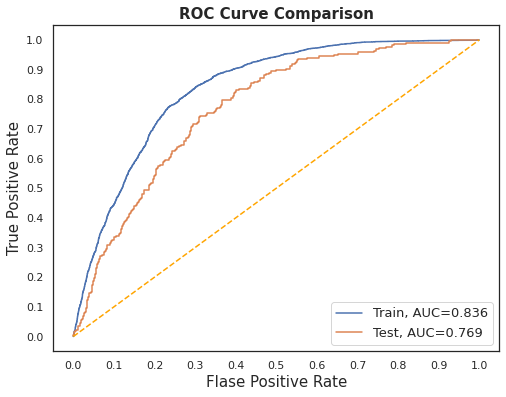

Training set
              precision    recall  f1-score   support

         0.0       0.73      0.66      0.70       429
         1.0       0.69      0.76      0.72       429

    accuracy                           0.71       858
   macro avg       0.71      0.71      0.71       858
weighted avg       0.71      0.71      0.71       858

Train AUC score: 0.7789459957292125
Test set
              precision    recall  f1-score   support

         0.0       0.97      0.65      0.78      1848
         1.0       0.22      0.83      0.35       218

    accuracy                           0.67      2066
   macro avg       0.59      0.74      0.56      2066
weighted avg       0.89      0.67      0.73      2066

Test AUC score: 0.7832916319154851


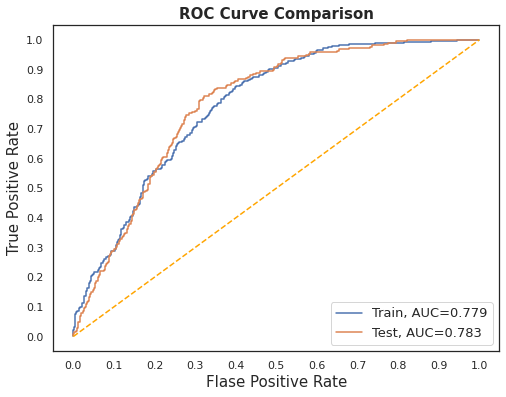

Training set
              precision    recall  f1-score   support

         0.0       0.73      0.67      0.70      4389
         1.0       0.69      0.75      0.72      4389

    accuracy                           0.71      8778
   macro avg       0.71      0.71      0.71      8778
weighted avg       0.71      0.71      0.71      8778

Train AUC score: 0.776456198803934
Test set
              precision    recall  f1-score   support

         0.0       0.97      0.66      0.79      1848
         1.0       0.22      0.81      0.35       218

    accuracy                           0.68      2066
   macro avg       0.59      0.74      0.57      2066
weighted avg       0.89      0.68      0.74      2066

Test AUC score: 0.7940868382382145


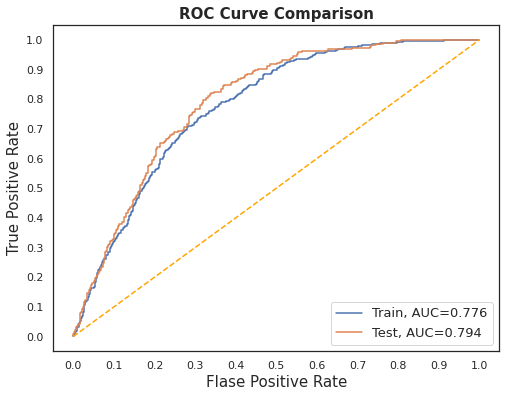

In [33]:
model = LogisticRegression(solver='newton-cg', class_weight='balanced', penalty='l2')

fitted_model_SMOTE = run_model(model, X_SMOTE_clv, y_SMOTE_clv, X_test_clv,  y_test_clv, xgb='no')
fitted_model_under = run_model(model, X_under_clv, y_under_clv, X_test_clv,  y_test_clv, xgb='no')
fitted_model_over = run_model(model, X_over_clv, y_over_clv, X_test_clv,  y_test_clv, xgb='no')

## **Random Forest**

Training set
              precision    recall  f1-score   support

         0.0       0.84      0.68      0.75      4389
         1.0       0.73      0.87      0.79      4389

    accuracy                           0.78      8778
   macro avg       0.79      0.78      0.77      8778
weighted avg       0.79      0.78      0.77      8778

Train AUC score: 0.8627925579395163
Test set
              precision    recall  f1-score   support

         0.0       0.96      0.67      0.79      1848
         1.0       0.21      0.73      0.33       218

    accuracy                           0.68      2066
   macro avg       0.58      0.70      0.56      2066
weighted avg       0.88      0.68      0.74      2066

Test AUC score: 0.7762532765399739


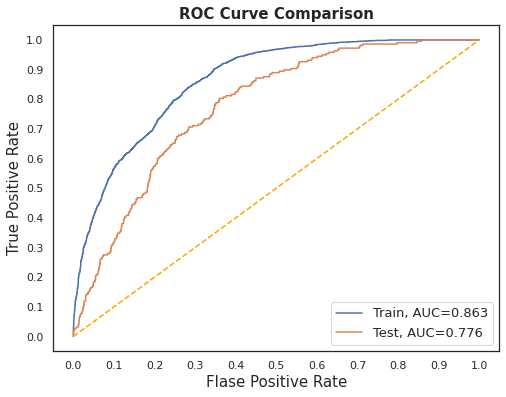

Training set
              precision    recall  f1-score   support

         0.0       0.85      0.66      0.74       429
         1.0       0.72      0.88      0.79       429

    accuracy                           0.77       858
   macro avg       0.78      0.77      0.77       858
weighted avg       0.78      0.77      0.77       858

Train AUC score: 0.8473274976771481
Test set
              precision    recall  f1-score   support

         0.0       0.97      0.58      0.72      1848
         1.0       0.19      0.85      0.31       218

    accuracy                           0.61      2066
   macro avg       0.58      0.72      0.52      2066
weighted avg       0.89      0.61      0.68      2066

Test AUC score: 0.7727446483180428


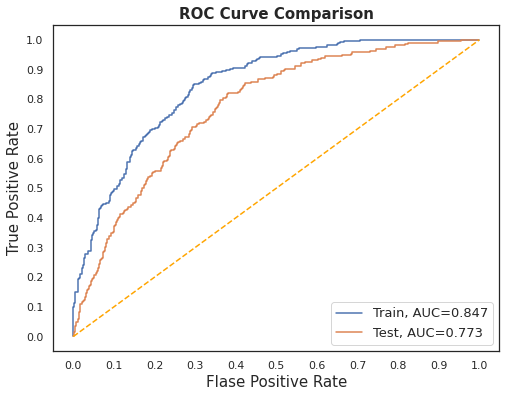

Training set
              precision    recall  f1-score   support

         0.0       0.83      0.65      0.73      4389
         1.0       0.71      0.87      0.78      4389

    accuracy                           0.76      8778
   macro avg       0.77      0.76      0.76      8778
weighted avg       0.77      0.76      0.76      8778

Train AUC score: 0.8244555546782405
Test set
              precision    recall  f1-score   support

         0.0       0.96      0.64      0.77      1848
         1.0       0.21      0.80      0.33       218

    accuracy                           0.66      2066
   macro avg       0.59      0.72      0.55      2066
weighted avg       0.88      0.66      0.72      2066

Test AUC score: 0.777264784145518


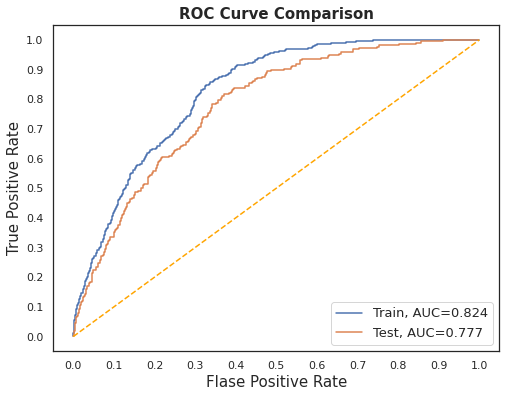

In [34]:
model = RandomForestClassifier(criterion='gini',
                                          max_depth=4,
                                          n_estimators=500,
                                          min_samples_split=3)

fitted_model_SMOTE = run_model(model, X_SMOTE_clv, y_SMOTE_clv, X_test_clv,  y_test_clv, xgb='no')
fitted_model_under = run_model(model, X_under_clv, y_under_clv, X_test_clv,  y_test_clv, xgb='no')
fitted_model_over = run_model(model, X_over_clv, y_over_clv, X_test_clv,  y_test_clv, xgb='no')

## **XGBoost**

[0]	validation_0-auc:0.721902
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.743991
[2]	validation_0-auc:0.742522
[3]	validation_0-auc:0.768886
[4]	validation_0-auc:0.773837
[5]	validation_0-auc:0.775392
[6]	validation_0-auc:0.784766
[7]	validation_0-auc:0.788008
[8]	validation_0-auc:0.788507
[9]	validation_0-auc:0.787271
[10]	validation_0-auc:0.787011
[11]	validation_0-auc:0.788935
[12]	validation_0-auc:0.789976
[13]	validation_0-auc:0.792348
[14]	validation_0-auc:0.792542
[15]	validation_0-auc:0.792249
[16]	validation_0-auc:0.79301
[17]	validation_0-auc:0.793295
[18]	validation_0-auc:0.792774
[19]	validation_0-auc:0.791967
[20]	validation_0-auc:0.791691
[21]	validation_0-auc:0.792051
[22]	validation_0-auc:0.791935
Stopping. Best iteration:
[17]	validation_0-auc:0.793295

Training set
              precision    recall  f1-score   support

         0.0       0.88      0.74      0.80      4389
         1.0       0.78      0.90      0.83      4389



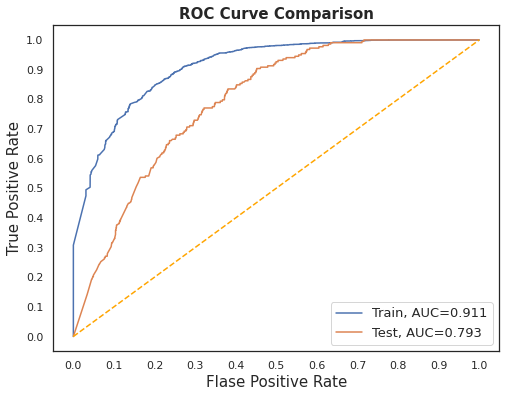

[0]	validation_0-auc:0.713933
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.732842
[2]	validation_0-auc:0.740276
[3]	validation_0-auc:0.753264
[4]	validation_0-auc:0.754735
[5]	validation_0-auc:0.759812
[6]	validation_0-auc:0.759859
[7]	validation_0-auc:0.765094
[8]	validation_0-auc:0.765402
[9]	validation_0-auc:0.764568
[10]	validation_0-auc:0.764654
[11]	validation_0-auc:0.764531
[12]	validation_0-auc:0.766086
[13]	validation_0-auc:0.766153
[14]	validation_0-auc:0.768607
[15]	validation_0-auc:0.768517
[16]	validation_0-auc:0.770142
[17]	validation_0-auc:0.770117
[18]	validation_0-auc:0.769894
[19]	validation_0-auc:0.771269
[20]	validation_0-auc:0.773818
[21]	validation_0-auc:0.774738
[22]	validation_0-auc:0.774509
[23]	validation_0-auc:0.775449
[24]	validation_0-auc:0.776255
[25]	validation_0-auc:0.777651
[26]	validation_0-auc:0.778336
[27]	validation_0-auc:0.777821
[28]	validation_0-auc:0.778712
[29]	validation_0-auc:0.778804
[30]	validation_0

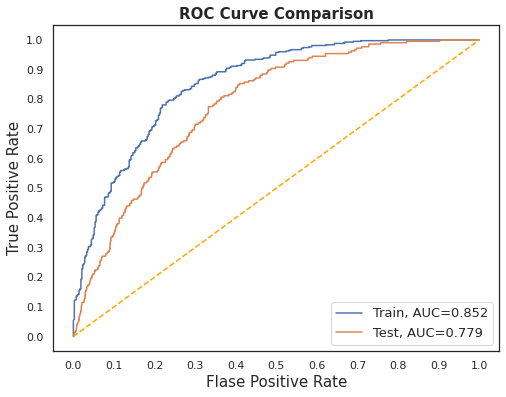

[0]	validation_0-auc:0.722518
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.733365
[2]	validation_0-auc:0.749129
[3]	validation_0-auc:0.759631
[4]	validation_0-auc:0.76536
[5]	validation_0-auc:0.766694
[6]	validation_0-auc:0.770342
[7]	validation_0-auc:0.77005
[8]	validation_0-auc:0.770375
[9]	validation_0-auc:0.77163
[10]	validation_0-auc:0.77119
[11]	validation_0-auc:0.771422
[12]	validation_0-auc:0.770905
[13]	validation_0-auc:0.774758
[14]	validation_0-auc:0.777575
[15]	validation_0-auc:0.779416
[16]	validation_0-auc:0.779845
[17]	validation_0-auc:0.780181
[18]	validation_0-auc:0.781409
[19]	validation_0-auc:0.781756
[20]	validation_0-auc:0.78162
[21]	validation_0-auc:0.781842
[22]	validation_0-auc:0.781796
[23]	validation_0-auc:0.783092
[24]	validation_0-auc:0.783176
[25]	validation_0-auc:0.782515
[26]	validation_0-auc:0.784137
[27]	validation_0-auc:0.783246
[28]	validation_0-auc:0.783722
[29]	validation_0-auc:0.784134
[30]	validation_0-auc:

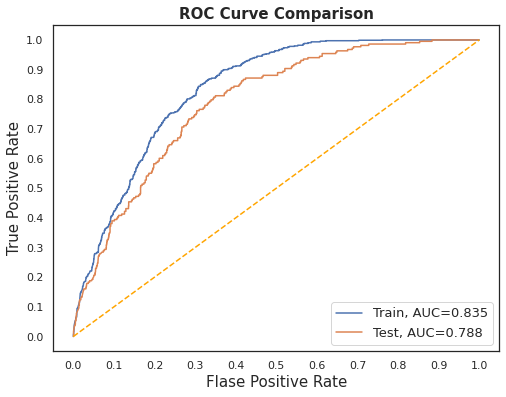

In [35]:
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
                          learning_rate =0.065,
                          n_estimators=1000,
                          max_depth=3,
                          gamma=0.3,
                          colsample_bytree=0.7,
                          min_child_weight = 4 )

fitted_model_SMOTE = run_model(model, X_SMOTE_clv, y_SMOTE_clv, X_test_clv,  y_test_clv, xgb='yes')
fitted_model_under = run_model(model, X_under_clv, y_under_clv, X_test_clv,  y_test_clv, xgb='yes')
fitted_model_over = run_model(model, X_over_clv, y_over_clv, X_test_clv,  y_test_clv, xgb='yes')

[0]	validation_0-auc:0.721902
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.743978
[2]	validation_0-auc:0.74256
[3]	validation_0-auc:0.768804
[4]	validation_0-auc:0.773926
[5]	validation_0-auc:0.775474
[6]	validation_0-auc:0.784734
[7]	validation_0-auc:0.784625
[8]	validation_0-auc:0.783789
[9]	validation_0-auc:0.782857
[10]	validation_0-auc:0.786733
[11]	validation_0-auc:0.788626
[12]	validation_0-auc:0.789356
[13]	validation_0-auc:0.790376
[14]	validation_0-auc:0.791545
[15]	validation_0-auc:0.791488
[16]	validation_0-auc:0.791905
[17]	validation_0-auc:0.791734
[18]	validation_0-auc:0.791793
[19]	validation_0-auc:0.791912
[20]	validation_0-auc:0.79187
[21]	validation_0-auc:0.791729
[22]	validation_0-auc:0.791823
[23]	validation_0-auc:0.792528
[24]	validation_0-auc:0.792552
[25]	validation_0-auc:0.792444
[26]	validation_0-auc:0.792074
[27]	validation_0-auc:0.792225
[28]	validation_0-auc:0.793127
[29]	validation_0-auc:0.792924
[30]	validation_0-a

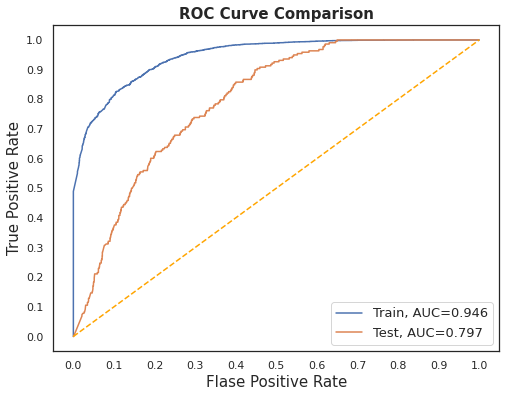

[0]	validation_0-auc:0.714804
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.734861
[2]	validation_0-auc:0.741655
[3]	validation_0-auc:0.754449
[4]	validation_0-auc:0.755882
[5]	validation_0-auc:0.761488
[6]	validation_0-auc:0.760943
[7]	validation_0-auc:0.760154
[8]	validation_0-auc:0.763364
[9]	validation_0-auc:0.765936
[10]	validation_0-auc:0.765762
[11]	validation_0-auc:0.767081
[12]	validation_0-auc:0.768463
[13]	validation_0-auc:0.77024
[14]	validation_0-auc:0.772031
[15]	validation_0-auc:0.771279
[16]	validation_0-auc:0.773184
[17]	validation_0-auc:0.772021
[18]	validation_0-auc:0.770795
[19]	validation_0-auc:0.772122
[20]	validation_0-auc:0.774555
[21]	validation_0-auc:0.774825
[22]	validation_0-auc:0.774312
[23]	validation_0-auc:0.775538
[24]	validation_0-auc:0.775757
[25]	validation_0-auc:0.776428
[26]	validation_0-auc:0.777444
[27]	validation_0-auc:0.776683
[28]	validation_0-auc:0.778224
[29]	validation_0-auc:0.777735
[30]	validation_0-

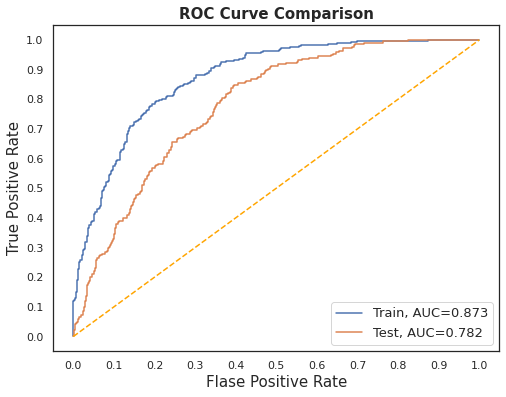

[0]	validation_0-auc:0.722518
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.733365
[2]	validation_0-auc:0.749129
[3]	validation_0-auc:0.759624
[4]	validation_0-auc:0.765147
[5]	validation_0-auc:0.766215
[6]	validation_0-auc:0.770632
[7]	validation_0-auc:0.770607
[8]	validation_0-auc:0.77048
[9]	validation_0-auc:0.770863
[10]	validation_0-auc:0.77012
[11]	validation_0-auc:0.770781
[12]	validation_0-auc:0.770629
[13]	validation_0-auc:0.772043
[14]	validation_0-auc:0.771947
[15]	validation_0-auc:0.775571
[16]	validation_0-auc:0.775869
[17]	validation_0-auc:0.775993
[18]	validation_0-auc:0.776966
[19]	validation_0-auc:0.777174
[20]	validation_0-auc:0.779357
[21]	validation_0-auc:0.778964
[22]	validation_0-auc:0.779611
[23]	validation_0-auc:0.780621
[24]	validation_0-auc:0.780108
[25]	validation_0-auc:0.781183
[26]	validation_0-auc:0.781253
[27]	validation_0-auc:0.780209
[28]	validation_0-auc:0.781522
[29]	validation_0-auc:0.78223
[30]	validation_0-au

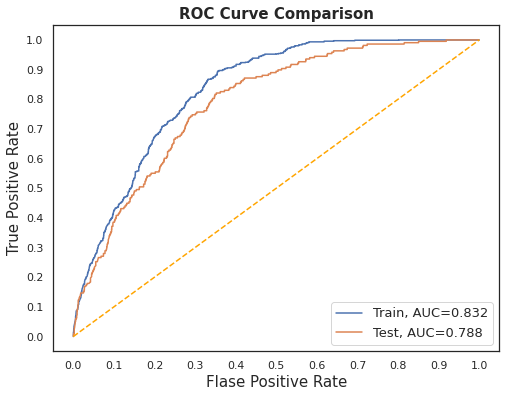

In [36]:
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
                          learning_rate =0.06,
                          n_estimators=1000,
                          max_depth=3,
                          gamma=0.5,
                          colsample_bytree=0.7,
                          min_child_weight = 5 )

fitted_model_SMOTE = run_model(model, X_SMOTE_clv, y_SMOTE_clv, X_test_clv,  y_test_clv, xgb='yes')
fitted_model_under = run_model(model, X_under_clv, y_under_clv, X_test_clv,  y_test_clv, xgb='yes')
fitted_model_over = run_model(model, X_over_clv, y_over_clv, X_test_clv,  y_test_clv, xgb='yes')

### Hyperparameter Exploration

In [37]:
X_train_load = X_over_clv
y_train_load = y_over_clv
X_test_load = X_test_clv 
y_test = y_test_clv

#### learning_rate

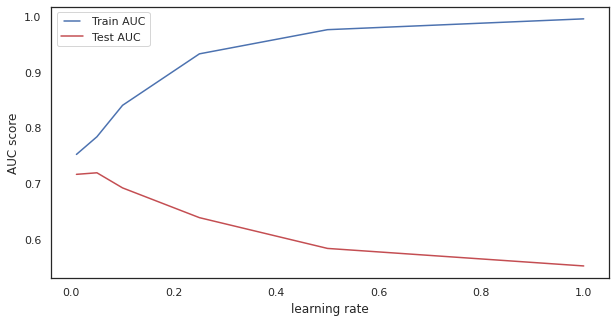

In [38]:
#Learning rate tuning
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []
for eta in learning_rates:
   model = xgb.XGBClassifier(learning_rate=eta)
   model.fit(X_train_load, y_train_load)
   train_pred = model.predict(X_train_load)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_load, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test_load)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

plt.figure(figsize=(10,5))
line1, = plt.plot(learning_rates, train_results, 'b', label='Train AUC')
line2, = plt.plot(learning_rates, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('learning rate')
plt.show()

#### max_depth

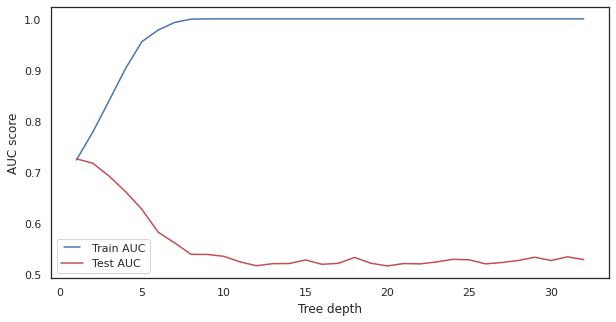

In [39]:
#Max depth tuning
max_depths = np.linspace(1, 32, 32, endpoint=True)
max_depths = [int(x) for x in max_depths]
train_results = []
test_results = []
for max_depth in max_depths:
   model = xgb.XGBClassifier(max_depth=max_depth)
   model.fit(X_train_load, y_train_load)
   train_pred = model.predict(X_train_load)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_load, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test_load)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
plt.figure(figsize=(10,5))
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

#### colsample_by_tree

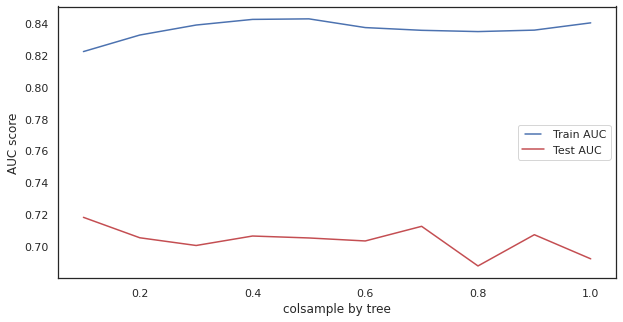

In [40]:
#colsample by tree tuning
colsamples = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for colsample in colsamples:
   model = xgb.XGBClassifier(colsample_bytree=colsample)
   model.fit(X_train_load, y_train_load)
   train_pred = model.predict(X_train_load)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_load, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test_load)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
plt.figure(figsize=(10,5))
line1, = plt.plot(colsamples, train_results, 'b', label="Train AUC")
line2, = plt.plot(colsamples, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel('colsample by tree')
plt.show()

#### min_child_weight

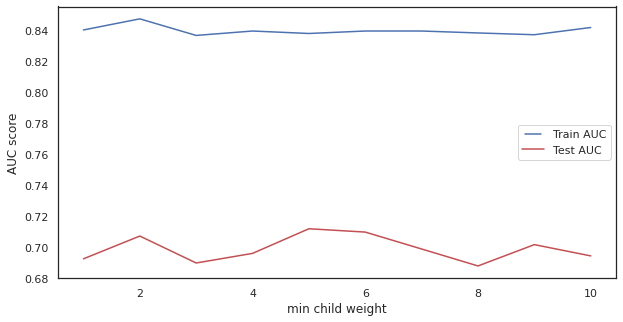

In [41]:
#min child weight tuning
minchilds = [x for x in range(1,11)]
train_results = []
test_results = []
for child in minchilds:
   model = xgb.XGBClassifier(min_child_weight=child)
   model.fit(X_train_load, y_train_load)
   train_pred = model.predict(X_train_load)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_load, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test_load)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
plt.figure(figsize=(10,5))
line1, = plt.plot(minchilds, train_results, 'b', label="Train AUC")
line2, = plt.plot(minchilds, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel('min child weight')
plt.show()

## **Grid Search**

In [42]:
# ## building pipeline for hyperparameter tuning

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

# Create a pipeline
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=9))
])

In [43]:
## hyper parameter tuning - grid search

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
# Define our search space for grid search
search_space = [
  {
    'clf__n_estimators': [300, 500],
    'clf__learning_rate': [0.01, 0.5],
    'clf__max_depth': range(2, 5),
    'clf__min_child_weight': range(1, 10),
    # 'clf__colsample_bytree': [i/10.0 for i in range(4, 7)],
    # 'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
    'fs__k': [2],
  }
]
# Define cross validation
kfold = KFold(n_splits=5, random_state=42, shuffle=True)
# AUC and F1 as score
scoring = {'AUC':'roc_auc','F1 score': 'f1_micro'}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

# Fit grid search
xgb_model_clv_GS = grid.fit(X_over_clv, y_over_clv)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [44]:
print(xgb_model_clv_GS.best_params_)

{'clf__learning_rate': 0.5, 'clf__max_depth': 4, 'clf__min_child_weight': 1, 'clf__n_estimators': 500, 'fs__k': 2, 'fs__score_func': <function chi2 at 0x7f141a1eed40>}


In [45]:
predicted_y = []
expected_y = []
predictions = xgb_model_clv_GS.predict(X_test_clv)
predictions_test = xgb_model_clv_GS.predict_proba(X_test_clv)
print('Best AUC Score: {}'.format(xgb_model_clv_GS.best_score_))
print(confusion_matrix(y_test_clv,predictions))


predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 
test_auc = roc_auc_score(y_test_clv, predictions_test[:,1])
print(f'Test AUC score: {test_auc}')

Best AUC Score: 0.9819786700583869
[[1592  256]
 [ 170   48]]
test set
              precision    recall  f1-score   support

         0.0       0.90      0.86      0.88      1848
         1.0       0.16      0.22      0.18       218

    accuracy                           0.79      2066
   macro avg       0.53      0.54      0.53      2066
weighted avg       0.82      0.79      0.81      2066

Test AUC score: 0.6372088347432383
